# <div align="center" style="color:rgb(51, 197, 255);">PSI Monitoring With Decile</div>

# Declare Libraries

In [1]:
# %% [markdown]
# # Jupyter Notebook Loading Header
#
# This is a custom loading header for Jupyter Notebooks in Visual Studio Code.
# It includes common imports and settings to get you started quickly.

# %% [markdown]
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import os
path = r'C:\Users\DwaipayanChakroborti\AppData\Roaming\gcloud\legacy_credentials\dchakroborti@tonikbank.com\adc.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path
client = bigquery.Client(project='prj-prod-dataplatform')

# %% [markdown]
## Configure Settings
# Set options or configurations as needed
# Example: pd.set_option('display.max_columns', None)

# s_apps_score

Job ID baf33837-76d0-42c0-850c-faebf09eaef0 successfully executed: 100%|██████████|

d:\Anaconda3\envs\inc_env\lib\site-packages\google\cloud\bigquery\table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



Downloading: 100%|██████████|
Population Stability Index Summary:
Month: 2024-08 - PSI: 0.0350 - No significant population change
Month: 2024-12 - PSI: 0.0281 - No significant population change
Month: 2024-11 - PSI: 0.0405 - No significant population change
Month: 2024-09 - PSI: 0.0453 - No significant population change
Month: 2025-01 - PSI: 0.0467 - No significant population change
Month: 2024-07 - PSI: 0.0343 - No significant population change
Month: 2024-10 - PSI: 0.0448 - No significant population change
Month: 2025-02 - PSI: 0.0502 - No significant population change


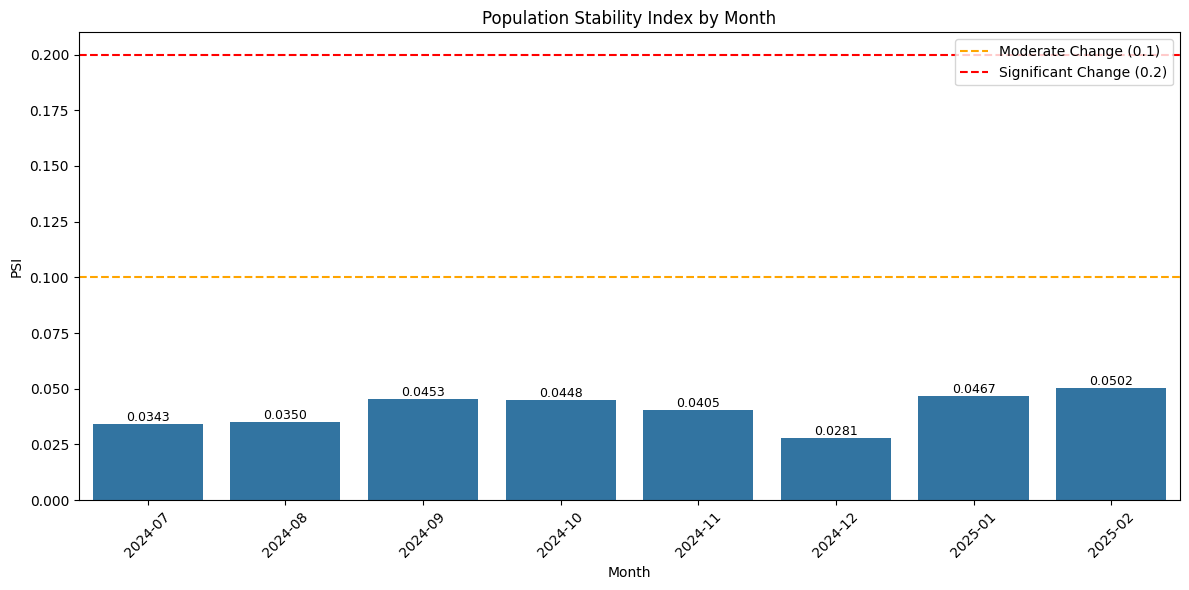

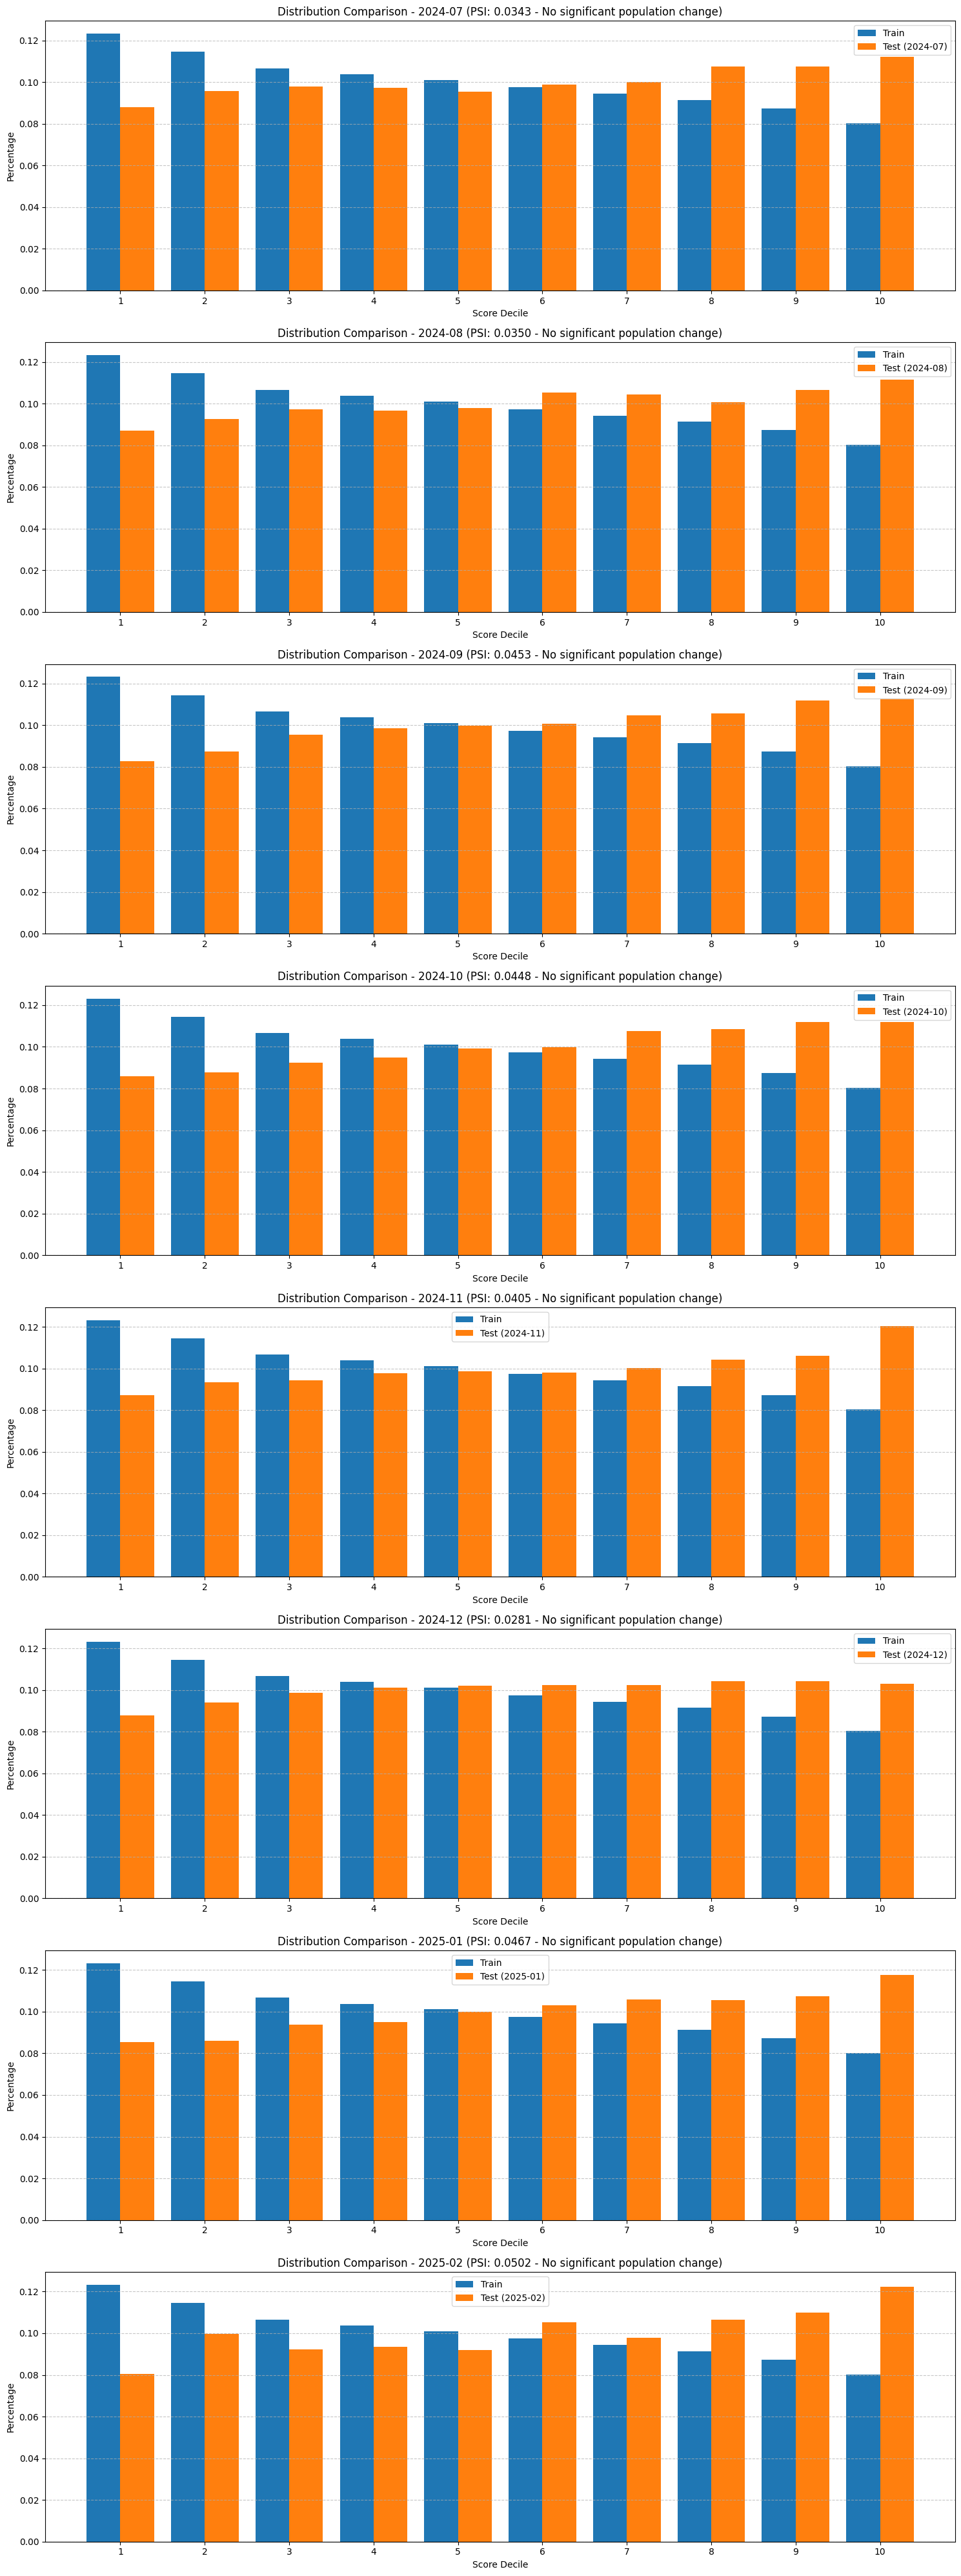

In [2]:
sq = """with base as 
(select 
  a.digitalLoanAccountId, 
  FORMAT_DATE('%Y-%m', a.ln_appln_submit_datetime) Application_month,
  FORMAT_DATE('%F', DATE_TRUNC(a.ln_appln_submit_datetime, WEEK(MONDAY))) as Appl_week_start_date,
  EXTRACT(WEEK(MONDAY) FROM a.ln_appln_submit_datetime) as Appl_week_number,
  NTILE(10) OVER (ORDER BY s_apps_score) AS s_apps_score_decile,
  case when date_trunc(a.ln_appln_submit_datetime, day) between '2023-07-01' and '2024-06-30' then 'Train'
       when date_trunc(a.ln_appln_submit_datetime, day) >= '2024-07-01' then 'Test'
       Else 'Other' end dataselection,
  a.s_apps_score,
 from 
 prj-prod-dataplatform.risk_mart.sil_risk_ds_master_20230101_20250206 a
 where a.ln_loan_applied_flag = 1 and ln_dl_rule_reject_flag = 0
 and date_trunc(a.ln_appln_submit_datetime, day) >= '2023-07-01'
 and s_apps_score is not null
 )
 select Application_month, Appl_week_start_date , dataselection, s_apps_score_decile,
 CONCAT(MIN(round(s_apps_score, 5)), ' - ', MAX(round(s_apps_score, 5))) AS s_apps_score_bin_range,
 count(distinct digitalLoanAccountId) app 
 from base where dataselection in ('Train', 'Test') 
 group by 1,2,3,4;"""
 
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')

def calculate_psi(df):
    """
    Calculate Population Stability Index (PSI) between Train set and each month in Test set
    
    Args:
        df: DataFrame with columns 'Application_month', 'dataselection', 's_apps_score_decile', 'app'
        
    Returns:
        DataFrame with PSI values for each Test month compared to the entire Train set
    """
    # Convert data to the right types if needed
    if isinstance(df['Application_month'].iloc[0], str):
        df['Application_month'] = pd.to_datetime(df['Application_month']).dt.strftime('%Y-%m')
    
    # Ensure s_apps_score_decile is an integer
    df['s_apps_score_decile'] = df['s_apps_score_decile'].astype(int)
    
    # First, get the distribution for the entire Train set
    train_data = df[df['dataselection'] == 'Train'].copy()
    train_total = train_data['app'].sum()
    
    # Calculate the distribution percentage for each decile in Train set
    train_distribution = train_data.groupby('s_apps_score_decile')['app'].sum().reset_index()
    train_distribution['percentage'] = train_distribution['app'] / train_total
    
    # Get unique test months
    test_data = df[df['dataselection'] == 'Test'].copy()
    test_months = test_data['Application_month'].unique()
    
    # Create a DataFrame to store PSI results
    psi_results = []
    
    # For each test month, calculate PSI
    for month in test_months:
        month_data = test_data[test_data['Application_month'] == month].copy()
        month_total = month_data['app'].sum()
        
        # Calculate the distribution percentage for each decile in this Test month
        month_distribution = month_data.groupby('s_apps_score_decile')['app'].sum().reset_index()
        month_distribution['percentage'] = month_distribution['app'] / month_total
        
        # Merge train and month distributions
        comparison = pd.merge(
            train_distribution[['s_apps_score_decile', 'percentage']], 
            month_distribution[['s_apps_score_decile', 'percentage']], 
            on='s_apps_score_decile', 
            how='outer',
            suffixes=('_train', '_test')
        ).fillna(0.0001)  # Replace NaN with small value to avoid division by zero
        
        # PSI calculation: sum((actual - expected) * ln(actual / expected))
        comparison['psi_component'] = (comparison['percentage_test'] - comparison['percentage_train']) * \
                                     np.log(comparison['percentage_test'] / comparison['percentage_train'])
        
        # Total PSI for this month
        month_psi = comparison['psi_component'].sum()
        
        psi_results.append({
            'month': month,
            'psi': month_psi,
            'distribution_comparison': comparison
        })
    
    # Create a summary DataFrame
    psi_summary = pd.DataFrame([{'month': r['month'], 'psi': r['psi']} for r in psi_results])
    
    return psi_summary, psi_results

def interpret_psi(psi_value):
    """Interpret PSI values"""
    if psi_value < 0.1:
        return "No significant population change"
    elif psi_value < 0.2:
        return "Moderate population change"
    else:
        return "Significant population change"

def plot_psi_results(psi_summary):
    """Create a bar chart of PSI values by month"""
    plt.figure(figsize=(12, 6))
    
    # Sort by month
    psi_summary = psi_summary.sort_values('month')
    
    # Create bar chart
    ax = sns.barplot(x='month', y='psi', data=psi_summary)
    
    # Add reference lines
    plt.axhline(y=0.1, color='orange', linestyle='--', label='Moderate Change (0.1)')
    plt.axhline(y=0.2, color='red', linestyle='--', label='Significant Change (0.2)')
    
    # Add labels
    plt.title('Population Stability Index by Month')
    plt.xlabel('Month')
    plt.ylabel('PSI')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # Add PSI values on top of bars
    for i, p in enumerate(ax.patches):
        ax.annotate(f"{p.get_height():.4f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=9)
    
    return plt

def plot_decile_distributions(psi_results):
    """Plot the distribution comparison for each test month"""
    plt.figure(figsize=(15, len(psi_results) * 5))
    
    for i, result in enumerate(sorted(psi_results, key=lambda x: x['month'])):
        plt.subplot(len(psi_results), 1, i+1)
        
        comparison = result['distribution_comparison']
        
        # Convert x to integer numpy array to avoid the float error
        x = comparison['s_apps_score_decile'].astype(int).values
        
        # Plot train and test distributions
        plt.bar(x - 0.2, comparison['percentage_train'], width=0.4, label='Train')
        plt.bar(x + 0.2, comparison['percentage_test'], width=0.4, label=f'Test ({result["month"]})')
        
        plt.title(f'Distribution Comparison - {result["month"]} (PSI: {result["psi"]:.4f} - {interpret_psi(result["psi"])})')
        plt.xlabel('Score Decile')
        plt.ylabel('Percentage')
        # Use explicit integer ticks to avoid the numpy rounding error
        plt.xticks(x)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return plt

# Example usage
def main(df):
    # Calculate PSI
    psi_summary, psi_results = calculate_psi(df)
    
    # Print summary
    print("Population Stability Index Summary:")
    for _, row in psi_summary.iterrows():
        print(f"Month: {row['month']} - PSI: {row['psi']:.4f} - {interpret_psi(row['psi'])}")
    
    try:
        # Plot results
        plot_psi = plot_psi_results(psi_summary)
        plot_psi.show()
        
        # Plot decile distributions
        plot_dist = plot_decile_distributions(psi_results)
        plot_dist.show()
    except Exception as e:
        print(f"Error during plotting: {e}")
        print("Returning PSI calculations without plots")
    
    return psi_summary, psi_results

# Run the main function
psi_summary, psi_results = main(df)

s_apps_score_psi_summary = psi_summary.copy()
s_apps_score_psi_results = psi_results.copy()


In [3]:
s_apps_score_psi_summary['scorename'] = 's_apps_score'
s_apps_score_psi_summary

month       psi     scorename
0  2024-08  0.035046  s_apps_score
1  2024-12  0.028071  s_apps_score
2  2024-11  0.040490  s_apps_score
3  2024-09  0.045277  s_apps_score
4  2025-01  0.046662  s_apps_score
5  2024-07  0.034278  s_apps_score
6  2024-10  0.044783  s_apps_score
7  2025-02  0.050160  s_apps_score

# sb_demo_score

Job ID 718c795d-c6ef-4c0b-a03e-7fc883178e5e successfully executed: 100%|██████████|

d:\Anaconda3\envs\inc_env\lib\site-packages\google\cloud\bigquery\table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



Downloading: 100%|██████████|
Population Stability Index Summary:
Month: 2024-08 - PSI: 0.0075 - No significant population change
Month: 2024-11 - PSI: 0.0129 - No significant population change
Month: 2024-09 - PSI: 0.0099 - No significant population change
Month: 2024-10 - PSI: 0.0094 - No significant population change
Month: 2024-12 - PSI: 0.0280 - No significant population change
Month: 2024-07 - PSI: 0.0073 - No significant population change
Month: 2025-01 - PSI: 0.0496 - No significant population change
Month: 2025-02 - PSI: 0.0510 - No significant population change


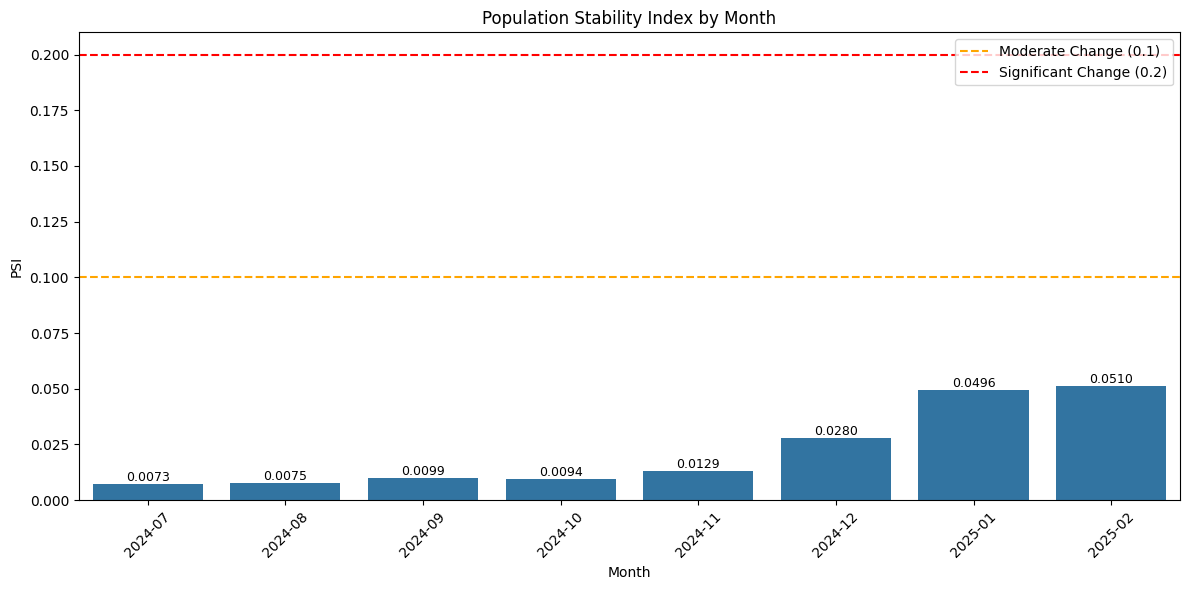

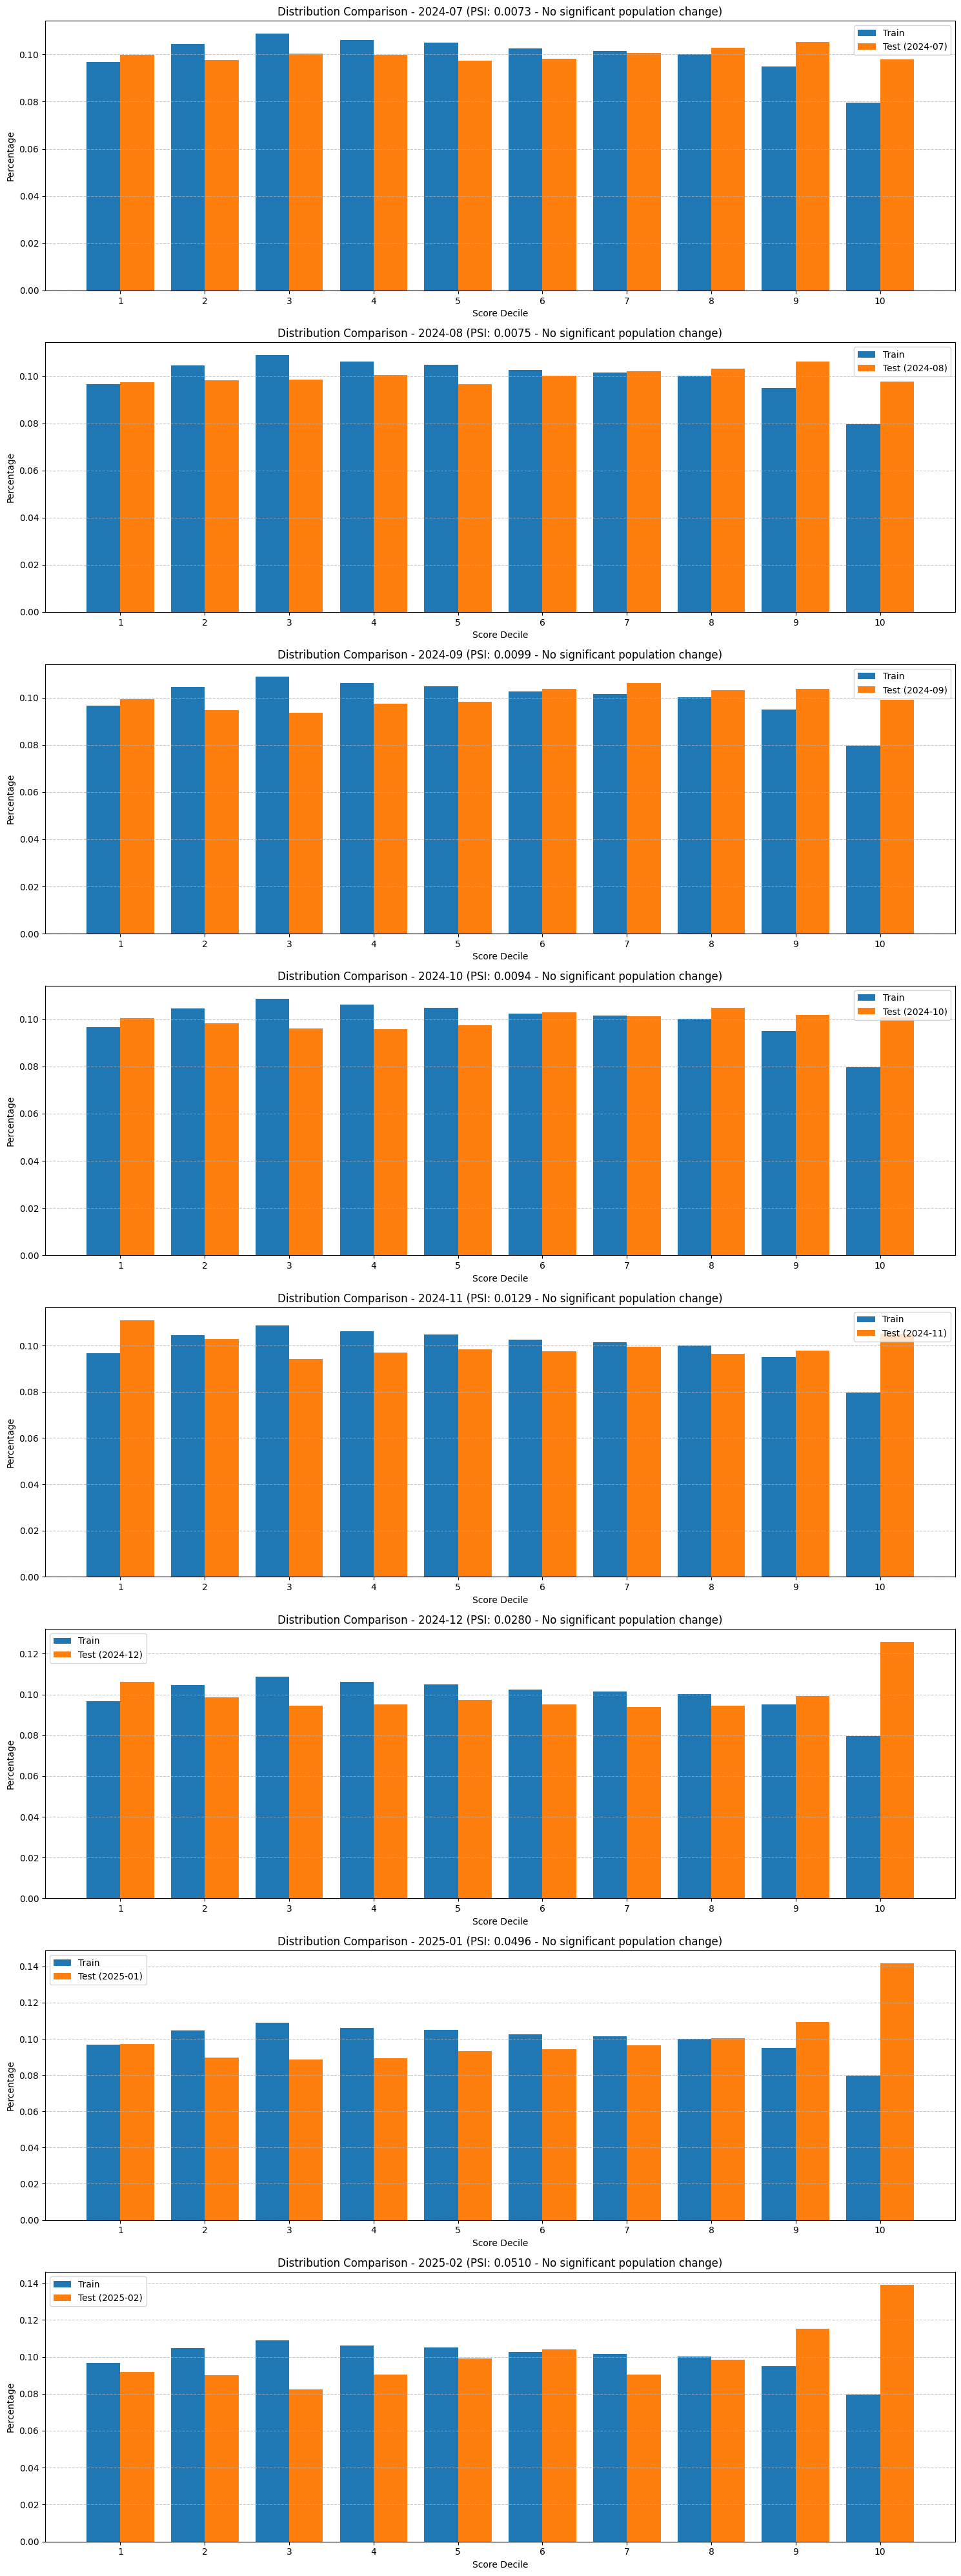

In [4]:
sq = """with base as 
(select 
  a.digitalLoanAccountId, 
  FORMAT_DATE('%Y-%m', a.ln_appln_submit_datetime) Application_month,
  FORMAT_DATE('%F', DATE_TRUNC(a.ln_appln_submit_datetime, WEEK(MONDAY))) as Appl_week_start_date,
  EXTRACT(WEEK(MONDAY) FROM a.ln_appln_submit_datetime) as Appl_week_number,
  NTILE(10) OVER (ORDER BY sb_demo_score) AS sb_demo_score_decile,
  case when date_trunc(a.ln_appln_submit_datetime, day) between '2023-07-01' and '2024-06-30' then 'Train'
       when date_trunc(a.ln_appln_submit_datetime, day) >= '2024-07-01' then 'Test'
       Else 'Other' end dataselection,
  a.sb_demo_score,
 from 
 prj-prod-dataplatform.risk_mart.sil_risk_ds_master_20230101_20250206 a
 where a.ln_loan_applied_flag = 1 and ln_dl_rule_reject_flag = 0
 and date_trunc(a.ln_appln_submit_datetime, day) >= '2023-07-01'
 and sb_demo_score is not null
 )
 select Application_month, Appl_week_start_date , dataselection, sb_demo_score_decile,
 CONCAT(MIN(round(sb_demo_score, 5)), ' - ', MAX(round(sb_demo_score, 5))) AS sb_demo_score_bin_range,
 count(distinct digitalLoanAccountId) app 
 from base where dataselection in ('Train', 'Test') 
 group by 1,2,3,4;"""
 
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')

def calculate_psi(df):
    """
    Calculate Population Stability Index (PSI) between Train set and each month in Test set
    
    Args:
        df: DataFrame with columns 'Application_month', 'dataselection', 'sb_demo_score_decile', 'app'
        
    Returns:
        DataFrame with PSI values for each Test month compared to the entire Train set
    """
    # Convert data to the right types if needed
    if isinstance(df['Application_month'].iloc[0], str):
        df['Application_month'] = pd.to_datetime(df['Application_month']).dt.strftime('%Y-%m')
    
    # Ensure sb_demo_score_decile is an integer
    df['sb_demo_score_decile'] = df['sb_demo_score_decile'].astype(int)
    
    # First, get the distribution for the entire Train set
    train_data = df[df['dataselection'] == 'Train'].copy()
    train_total = train_data['app'].sum()
    
    # Calculate the distribution percentage for each decile in Train set
    train_distribution = train_data.groupby('sb_demo_score_decile')['app'].sum().reset_index()
    train_distribution['percentage'] = train_distribution['app'] / train_total
    
    # Get unique test months
    test_data = df[df['dataselection'] == 'Test'].copy()
    test_months = test_data['Application_month'].unique()
    
    # Create a DataFrame to store PSI results
    psi_results = []
    
    # For each test month, calculate PSI
    for month in test_months:
        month_data = test_data[test_data['Application_month'] == month].copy()
        month_total = month_data['app'].sum()
        
        # Calculate the distribution percentage for each decile in this Test month
        month_distribution = month_data.groupby('sb_demo_score_decile')['app'].sum().reset_index()
        month_distribution['percentage'] = month_distribution['app'] / month_total
        
        # Merge train and month distributions
        comparison = pd.merge(
            train_distribution[['sb_demo_score_decile', 'percentage']], 
            month_distribution[['sb_demo_score_decile', 'percentage']], 
            on='sb_demo_score_decile', 
            how='outer',
            suffixes=('_train', '_test')
        ).fillna(0.0001)  # Replace NaN with small value to avoid division by zero
        
        # PSI calculation: sum((actual - expected) * ln(actual / expected))
        comparison['psi_component'] = (comparison['percentage_test'] - comparison['percentage_train']) * \
                                     np.log(comparison['percentage_test'] / comparison['percentage_train'])
        
        # Total PSI for this month
        month_psi = comparison['psi_component'].sum()
        
        psi_results.append({
            'month': month,
            'psi': month_psi,
            'distribution_comparison': comparison
        })
    
    # Create a summary DataFrame
    psi_summary = pd.DataFrame([{'month': r['month'], 'psi': r['psi']} for r in psi_results])
    
    return psi_summary, psi_results

def interpret_psi(psi_value):
    """Interpret PSI values"""
    if psi_value < 0.1:
        return "No significant population change"
    elif psi_value < 0.2:
        return "Moderate population change"
    else:
        return "Significant population change"

def plot_psi_results(psi_summary):
    """Create a bar chart of PSI values by month"""
    plt.figure(figsize=(12, 6))
    
    # Sort by month
    psi_summary = psi_summary.sort_values('month')
    
    # Create bar chart
    ax = sns.barplot(x='month', y='psi', data=psi_summary)
    
    # Add reference lines
    plt.axhline(y=0.1, color='orange', linestyle='--', label='Moderate Change (0.1)')
    plt.axhline(y=0.2, color='red', linestyle='--', label='Significant Change (0.2)')
    
    # Add labels
    plt.title('Population Stability Index by Month')
    plt.xlabel('Month')
    plt.ylabel('PSI')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # Add PSI values on top of bars
    for i, p in enumerate(ax.patches):
        ax.annotate(f"{p.get_height():.4f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=9)
    
    return plt

def plot_decile_distributions(psi_results):
    """Plot the distribution comparison for each test month"""
    plt.figure(figsize=(15, len(psi_results) * 5))
    
    for i, result in enumerate(sorted(psi_results, key=lambda x: x['month'])):
        plt.subplot(len(psi_results), 1, i+1)
        
        comparison = result['distribution_comparison']
        
        # Convert x to integer numpy array to avoid the float error
        x = comparison['sb_demo_score_decile'].astype(int).values
        
        # Plot train and test distributions
        plt.bar(x - 0.2, comparison['percentage_train'], width=0.4, label='Train')
        plt.bar(x + 0.2, comparison['percentage_test'], width=0.4, label=f'Test ({result["month"]})')
        
        plt.title(f'Distribution Comparison - {result["month"]} (PSI: {result["psi"]:.4f} - {interpret_psi(result["psi"])})')
        plt.xlabel('Score Decile')
        plt.ylabel('Percentage')
        # Use explicit integer ticks to avoid the numpy rounding error
        plt.xticks(x)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return plt

# Example usage
def main(df):
    # Calculate PSI
    psi_summary, psi_results = calculate_psi(df)
    
    # Print summary
    print("Population Stability Index Summary:")
    for _, row in psi_summary.iterrows():
        print(f"Month: {row['month']} - PSI: {row['psi']:.4f} - {interpret_psi(row['psi'])}")
    
    try:
        # Plot results
        plot_psi = plot_psi_results(psi_summary)
        plot_psi.show()
        
        # Plot decile distributions
        plot_dist = plot_decile_distributions(psi_results)
        plot_dist.show()
    except Exception as e:
        print(f"Error during plotting: {e}")
        print("Returning PSI calculations without plots")
    
    return psi_summary, psi_results

# Run the main function
psi_summary, psi_results = main(df)

sb_demo_score_psi_summary = psi_summary.copy()
sb_demo_score_psi_results = psi_results.copy()


In [5]:
sb_demo_score_psi_summary['scorename'] = 'sb_demo_score'
sb_demo_score_psi_summary

month       psi      scorename
0  2024-08  0.007503  sb_demo_score
1  2024-11  0.012902  sb_demo_score
2  2024-09  0.009928  sb_demo_score
3  2024-10  0.009387  sb_demo_score
4  2024-12  0.028020  sb_demo_score
5  2024-07  0.007315  sb_demo_score
6  2025-01  0.049555  sb_demo_score
7  2025-02  0.051008  sb_demo_score

# s_cic_score

Job ID 8079d390-b7da-4fbb-b98e-a50862ef125c successfully executed: 100%|██████████|

d:\Anaconda3\envs\inc_env\lib\site-packages\google\cloud\bigquery\table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



Downloading: 100%|██████████|
Population Stability Index Summary:
Month: 2024-12 - PSI: 0.0176 - No significant population change
Month: 2024-11 - PSI: 0.0173 - No significant population change
Month: 2024-08 - PSI: 0.0521 - No significant population change
Month: 2025-01 - PSI: 0.0254 - No significant population change
Month: 2025-02 - PSI: 0.0245 - No significant population change
Month: 2024-09 - PSI: 0.0302 - No significant population change
Month: 2024-07 - PSI: 0.0777 - No significant population change
Month: 2024-10 - PSI: 0.0231 - No significant population change


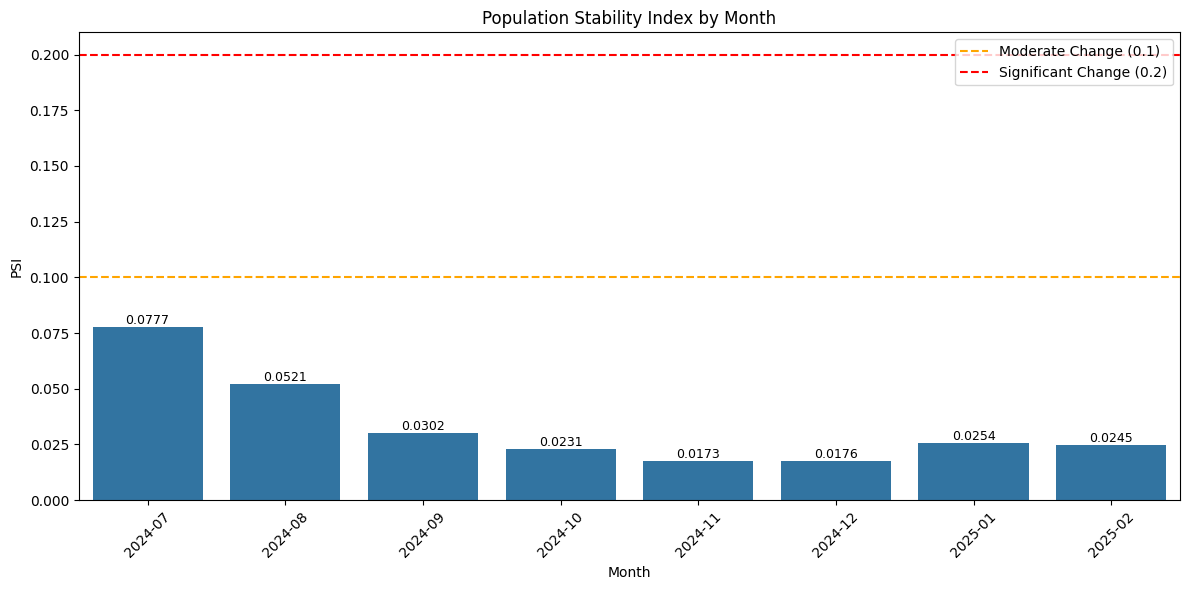

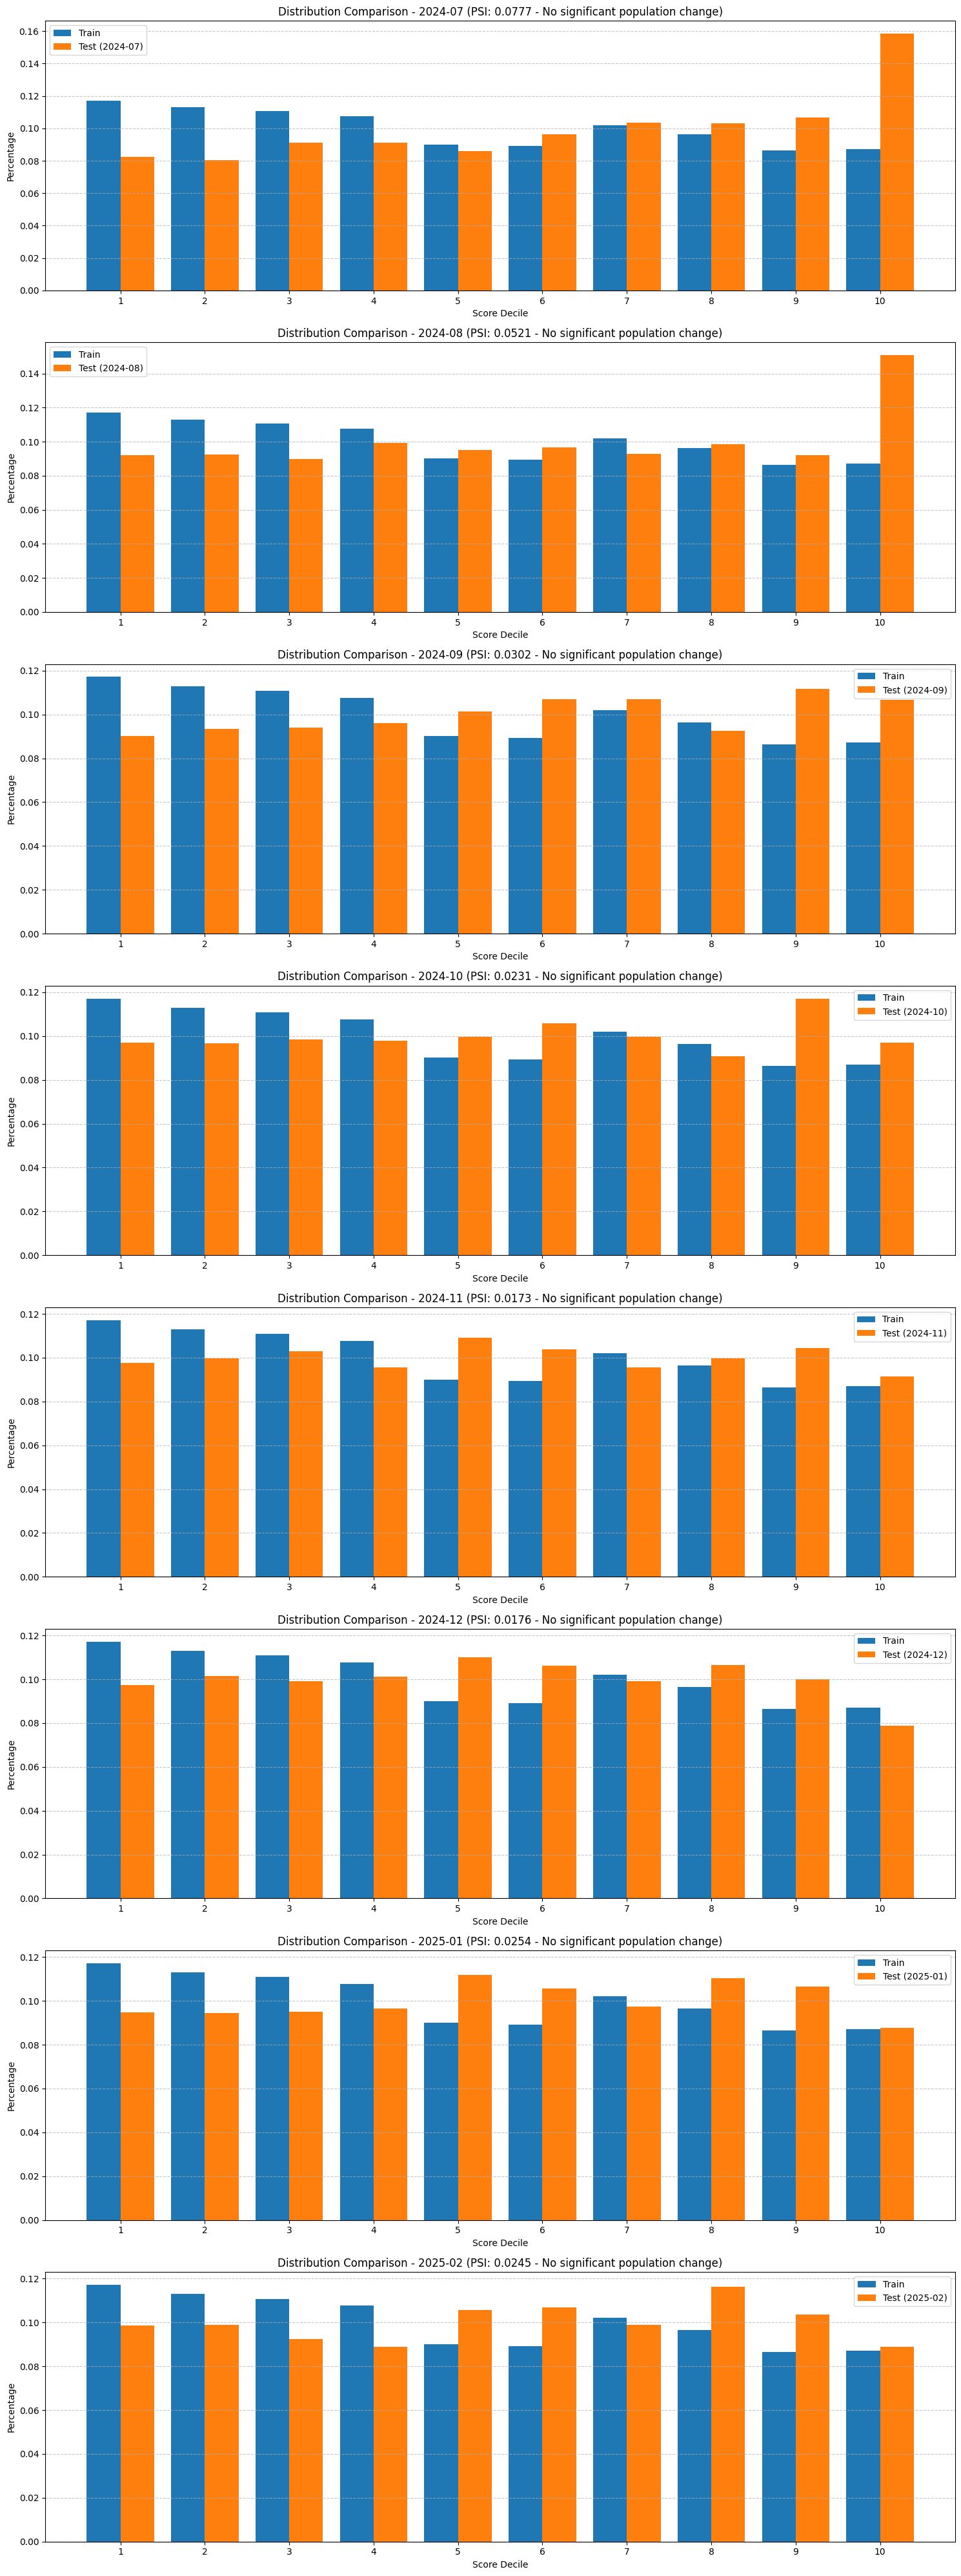

In [6]:
sq = """with base as 
(select 
  a.digitalLoanAccountId, 
  FORMAT_DATE('%Y-%m', a.ln_appln_submit_datetime) Application_month,
  FORMAT_DATE('%F', DATE_TRUNC(a.ln_appln_submit_datetime, WEEK(MONDAY))) as Appl_week_start_date,
  EXTRACT(WEEK(MONDAY) FROM a.ln_appln_submit_datetime) as Appl_week_number,
  NTILE(10) OVER (ORDER BY s_cic_score) AS s_cic_score_decile,
  case when date_trunc(a.ln_appln_submit_datetime, day) between '2023-07-01' and '2024-06-30' then 'Train'
       when date_trunc(a.ln_appln_submit_datetime, day) >= '2024-07-01' then 'Test'
       Else 'Other' end dataselection,
  a.s_cic_score,
 from 
 prj-prod-dataplatform.risk_mart.sil_risk_ds_master_20230101_20250206 a
 where a.ln_loan_applied_flag = 1 and ln_dl_rule_reject_flag = 0
 and date_trunc(a.ln_appln_submit_datetime, day) >= '2023-07-01'
 and s_cic_score is not null
 )
 select Application_month, Appl_week_start_date , dataselection, s_cic_score_decile,
 CONCAT(MIN(round(s_cic_score, 5)), ' - ', MAX(round(s_cic_score, 5))) AS s_cic_score_bin_range,
 count(distinct digitalLoanAccountId) app 
 from base where dataselection in ('Train', 'Test') 
 group by 1,2,3,4;"""
 
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')

def calculate_psi(df):
    """
    Calculate Population Stability Index (PSI) between Train set and each month in Test set
    
    Args:
        df: DataFrame with columns 'Application_month', 'dataselection', 's_cic_score_decile', 'app'
        
    Returns:
        DataFrame with PSI values for each Test month compared to the entire Train set
    """
    # Convert data to the right types if needed
    if isinstance(df['Application_month'].iloc[0], str):
        df['Application_month'] = pd.to_datetime(df['Application_month']).dt.strftime('%Y-%m')
    
    # Ensure s_cic_score_decile is an integer
    df['s_cic_score_decile'] = df['s_cic_score_decile'].astype(int)
    
    # First, get the distribution for the entire Train set
    train_data = df[df['dataselection'] == 'Train'].copy()
    train_total = train_data['app'].sum()
    
    # Calculate the distribution percentage for each decile in Train set
    train_distribution = train_data.groupby('s_cic_score_decile')['app'].sum().reset_index()
    train_distribution['percentage'] = train_distribution['app'] / train_total
    
    # Get unique test months
    test_data = df[df['dataselection'] == 'Test'].copy()
    test_months = test_data['Application_month'].unique()
    
    # Create a DataFrame to store PSI results
    psi_results = []
    
    # For each test month, calculate PSI
    for month in test_months:
        month_data = test_data[test_data['Application_month'] == month].copy()
        month_total = month_data['app'].sum()
        
        # Calculate the distribution percentage for each decile in this Test month
        month_distribution = month_data.groupby('s_cic_score_decile')['app'].sum().reset_index()
        month_distribution['percentage'] = month_distribution['app'] / month_total
        
        # Merge train and month distributions
        comparison = pd.merge(
            train_distribution[['s_cic_score_decile', 'percentage']], 
            month_distribution[['s_cic_score_decile', 'percentage']], 
            on='s_cic_score_decile', 
            how='outer',
            suffixes=('_train', '_test')
        ).fillna(0.0001)  # Replace NaN with small value to avoid division by zero
        
        # PSI calculation: sum((actual - expected) * ln(actual / expected))
        comparison['psi_component'] = (comparison['percentage_test'] - comparison['percentage_train']) * \
                                     np.log(comparison['percentage_test'] / comparison['percentage_train'])
        
        # Total PSI for this month
        month_psi = comparison['psi_component'].sum()
        
        psi_results.append({
            'month': month,
            'psi': month_psi,
            'distribution_comparison': comparison
        })
    
    # Create a summary DataFrame
    psi_summary = pd.DataFrame([{'month': r['month'], 'psi': r['psi']} for r in psi_results])
    
    return psi_summary, psi_results

def interpret_psi(psi_value):
    """Interpret PSI values"""
    if psi_value < 0.1:
        return "No significant population change"
    elif psi_value < 0.2:
        return "Moderate population change"
    else:
        return "Significant population change"

def plot_psi_results(psi_summary):
    """Create a bar chart of PSI values by month"""
    plt.figure(figsize=(12, 6))
    
    # Sort by month
    psi_summary = psi_summary.sort_values('month')
    
    # Create bar chart
    ax = sns.barplot(x='month', y='psi', data=psi_summary)
    
    # Add reference lines
    plt.axhline(y=0.1, color='orange', linestyle='--', label='Moderate Change (0.1)')
    plt.axhline(y=0.2, color='red', linestyle='--', label='Significant Change (0.2)')
    
    # Add labels
    plt.title('Population Stability Index by Month')
    plt.xlabel('Month')
    plt.ylabel('PSI')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # Add PSI values on top of bars
    for i, p in enumerate(ax.patches):
        ax.annotate(f"{p.get_height():.4f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=9)
    
    return plt

def plot_decile_distributions(psi_results):
    """Plot the distribution comparison for each test month"""
    plt.figure(figsize=(15, len(psi_results) * 5))
    
    for i, result in enumerate(sorted(psi_results, key=lambda x: x['month'])):
        plt.subplot(len(psi_results), 1, i+1)
        
        comparison = result['distribution_comparison']
        
        # Convert x to integer numpy array to avoid the float error
        x = comparison['s_cic_score_decile'].astype(int).values
        
        # Plot train and test distributions
        plt.bar(x - 0.2, comparison['percentage_train'], width=0.4, label='Train')
        plt.bar(x + 0.2, comparison['percentage_test'], width=0.4, label=f'Test ({result["month"]})')
        
        plt.title(f'Distribution Comparison - {result["month"]} (PSI: {result["psi"]:.4f} - {interpret_psi(result["psi"])})')
        plt.xlabel('Score Decile')
        plt.ylabel('Percentage')
        # Use explicit integer ticks to avoid the numpy rounding error
        plt.xticks(x)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return plt

# Example usage
def main(df):
    # Calculate PSI
    psi_summary, psi_results = calculate_psi(df)
    
    # Print summary
    print("Population Stability Index Summary:")
    for _, row in psi_summary.iterrows():
        print(f"Month: {row['month']} - PSI: {row['psi']:.4f} - {interpret_psi(row['psi'])}")
    
    try:
        # Plot results
        plot_psi = plot_psi_results(psi_summary)
        plot_psi.show()
        
        # Plot decile distributions
        plot_dist = plot_decile_distributions(psi_results)
        plot_dist.show()
    except Exception as e:
        print(f"Error during plotting: {e}")
        print("Returning PSI calculations without plots")
    
    return psi_summary, psi_results

# Run the main function
psi_summary, psi_results = main(df)

s_cic_score_psi_summary = psi_summary.copy()
s_cic_score_psi_results = psi_results.copy()


In [7]:
s_cic_score_psi_summary['scorename'] = 's_cic_score'
s_cic_score_psi_summary

month       psi    scorename
0  2024-12  0.017552  s_cic_score
1  2024-11  0.017327  s_cic_score
2  2024-08  0.052075  s_cic_score
3  2025-01  0.025401  s_cic_score
4  2025-02  0.024515  s_cic_score
5  2024-09  0.030206  s_cic_score
6  2024-07  0.077736  s_cic_score
7  2024-10  0.023145  s_cic_score

# sb_stack_score

Job ID 68670ee8-dd03-45f8-8ae6-05c02305cb1a successfully executed: 100%|██████████|

d:\Anaconda3\envs\inc_env\lib\site-packages\google\cloud\bigquery\table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



Downloading: 100%|██████████|
Population Stability Index Summary:
Month: 2025-01 - PSI: 0.1781 - Moderate population change
Month: 2024-12 - PSI: 0.0313 - No significant population change
Month: 2024-11 - PSI: 0.0341 - No significant population change
Month: 2024-10 - PSI: 0.0308 - No significant population change
Month: 2024-08 - PSI: 0.0333 - No significant population change
Month: 2025-02 - PSI: 0.1915 - Moderate population change
Month: 2024-09 - PSI: 0.0434 - No significant population change
Month: 2024-07 - PSI: 0.0327 - No significant population change


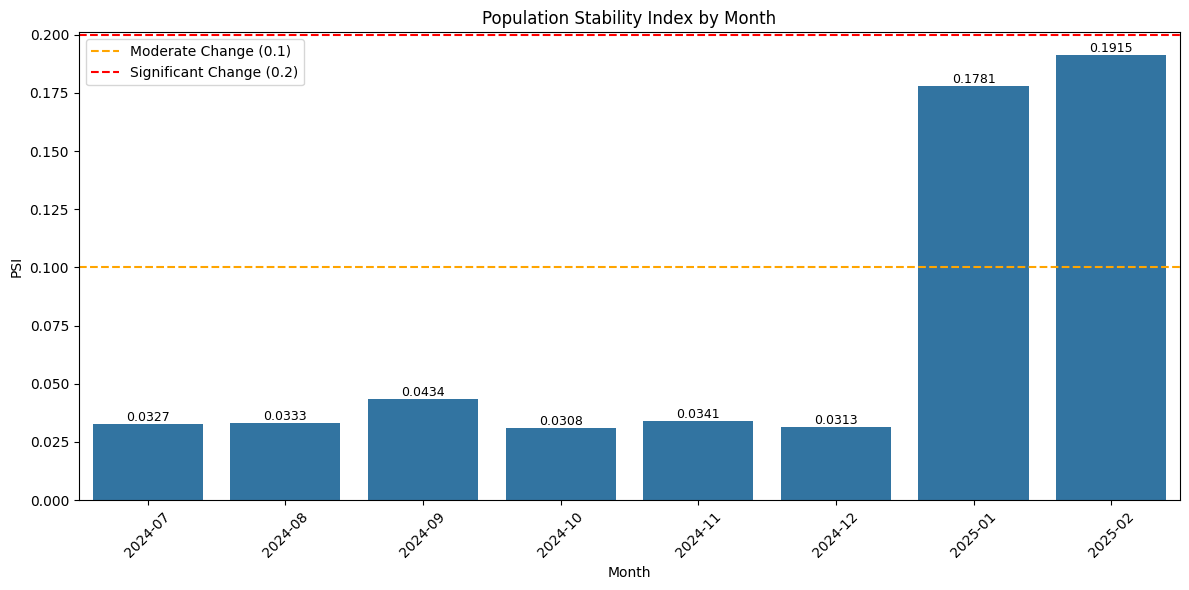

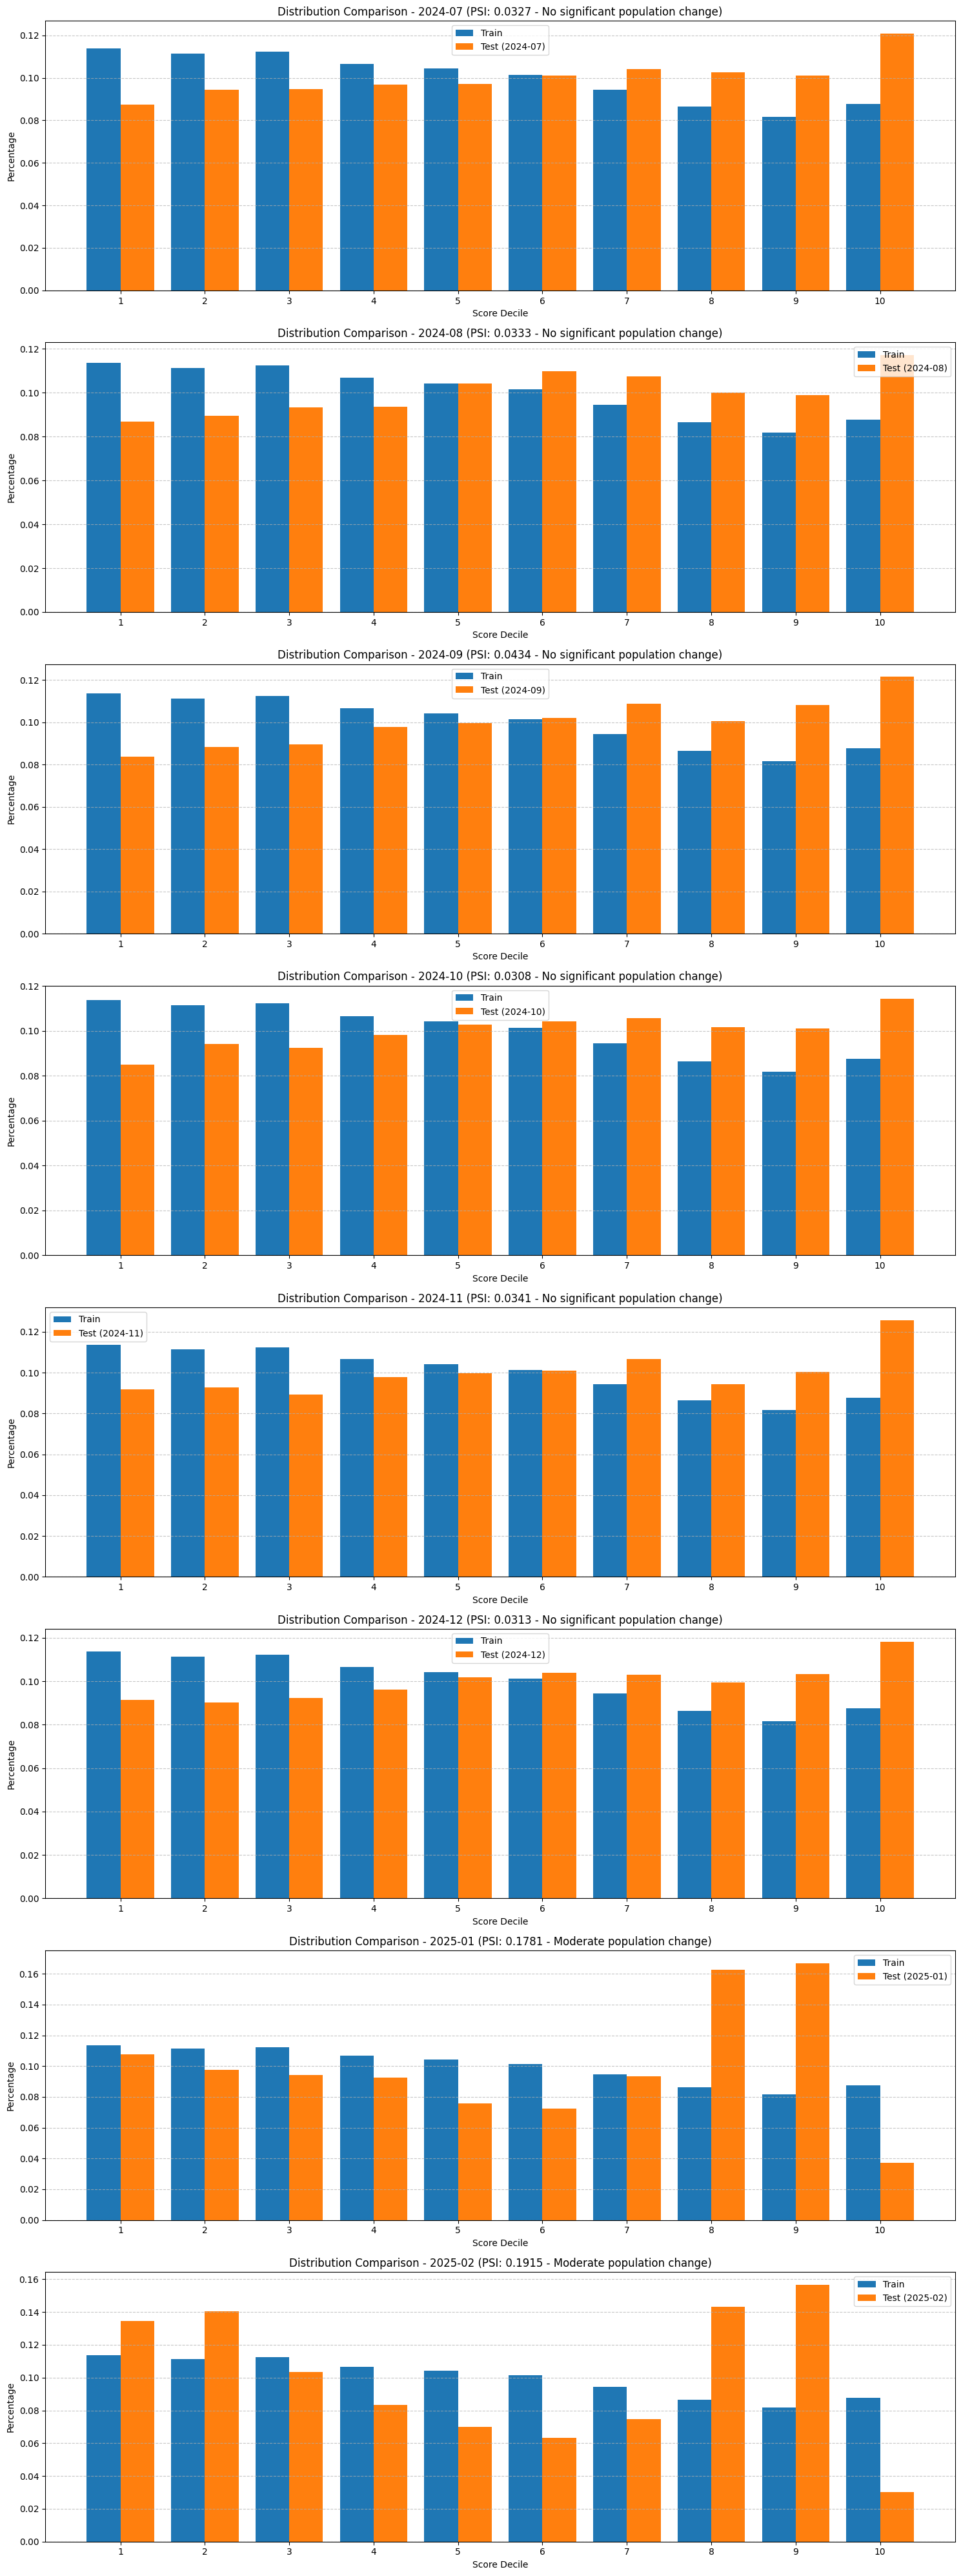

In [8]:
sq = """with base as 
(select 
  a.digitalLoanAccountId, 
  FORMAT_DATE('%Y-%m', a.ln_appln_submit_datetime) Application_month,
  FORMAT_DATE('%F', DATE_TRUNC(a.ln_appln_submit_datetime, WEEK(MONDAY))) as Appl_week_start_date,
  EXTRACT(WEEK(MONDAY) FROM a.ln_appln_submit_datetime) as Appl_week_number,
  NTILE(10) OVER (ORDER BY sb_stack_score) AS sb_stack_score_decile,
  case when date_trunc(a.ln_appln_submit_datetime, day) between '2023-07-01' and '2024-06-30' then 'Train'
       when date_trunc(a.ln_appln_submit_datetime, day) >= '2024-07-01' then 'Test'
       Else 'Other' end dataselection,
  a.sb_stack_score,
 from 
 prj-prod-dataplatform.risk_mart.sil_risk_ds_master_20230101_20250206 a
 where a.ln_loan_applied_flag = 1 and ln_dl_rule_reject_flag = 0
 and date_trunc(a.ln_appln_submit_datetime, day) >= '2023-07-01'
 and sb_stack_score is not null
 )
 select Application_month, Appl_week_start_date , dataselection, sb_stack_score_decile,
 CONCAT(MIN(round(sb_stack_score, 5)), ' - ', MAX(round(sb_stack_score, 5))) AS sb_stack_score_bin_range,
 count(distinct digitalLoanAccountId) app 
 from base where dataselection in ('Train', 'Test') 
 group by 1,2,3,4;"""
 
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')

def calculate_psi(df):
    """
    Calculate Population Stability Index (PSI) between Train set and each month in Test set
    
    Args:
        df: DataFrame with columns 'Application_month', 'dataselection', 'sb_stack_score_decile', 'app'
        
    Returns:
        DataFrame with PSI values for each Test month compared to the entire Train set
    """
    # Convert data to the right types if needed
    if isinstance(df['Application_month'].iloc[0], str):
        df['Application_month'] = pd.to_datetime(df['Application_month']).dt.strftime('%Y-%m')
    
    # Ensure sb_stack_score_decile is an integer
    df['sb_stack_score_decile'] = df['sb_stack_score_decile'].astype(int)
    
    # First, get the distribution for the entire Train set
    train_data = df[df['dataselection'] == 'Train'].copy()
    train_total = train_data['app'].sum()
    
    # Calculate the distribution percentage for each decile in Train set
    train_distribution = train_data.groupby('sb_stack_score_decile')['app'].sum().reset_index()
    train_distribution['percentage'] = train_distribution['app'] / train_total
    
    # Get unique test months
    test_data = df[df['dataselection'] == 'Test'].copy()
    test_months = test_data['Application_month'].unique()
    
    # Create a DataFrame to store PSI results
    psi_results = []
    
    # For each test month, calculate PSI
    for month in test_months:
        month_data = test_data[test_data['Application_month'] == month].copy()
        month_total = month_data['app'].sum()
        
        # Calculate the distribution percentage for each decile in this Test month
        month_distribution = month_data.groupby('sb_stack_score_decile')['app'].sum().reset_index()
        month_distribution['percentage'] = month_distribution['app'] / month_total
        
        # Merge train and month distributions
        comparison = pd.merge(
            train_distribution[['sb_stack_score_decile', 'percentage']], 
            month_distribution[['sb_stack_score_decile', 'percentage']], 
            on='sb_stack_score_decile', 
            how='outer',
            suffixes=('_train', '_test')
        ).fillna(0.0001)  # Replace NaN with small value to avoid division by zero
        
        # PSI calculation: sum((actual - expected) * ln(actual / expected))
        comparison['psi_component'] = (comparison['percentage_test'] - comparison['percentage_train']) * \
                                     np.log(comparison['percentage_test'] / comparison['percentage_train'])
        
        # Total PSI for this month
        month_psi = comparison['psi_component'].sum()
        
        psi_results.append({
            'month': month,
            'psi': month_psi,
            'distribution_comparison': comparison
        })
    
    # Create a summary DataFrame
    psi_summary = pd.DataFrame([{'month': r['month'], 'psi': r['psi']} for r in psi_results])
    
    return psi_summary, psi_results

def interpret_psi(psi_value):
    """Interpret PSI values"""
    if psi_value < 0.1:
        return "No significant population change"
    elif psi_value < 0.2:
        return "Moderate population change"
    else:
        return "Significant population change"

def plot_psi_results(psi_summary):
    """Create a bar chart of PSI values by month"""
    plt.figure(figsize=(12, 6))
    
    # Sort by month
    psi_summary = psi_summary.sort_values('month')
    
    # Create bar chart
    ax = sns.barplot(x='month', y='psi', data=psi_summary)
    
    # Add reference lines
    plt.axhline(y=0.1, color='orange', linestyle='--', label='Moderate Change (0.1)')
    plt.axhline(y=0.2, color='red', linestyle='--', label='Significant Change (0.2)')
    
    # Add labels
    plt.title('Population Stability Index by Month')
    plt.xlabel('Month')
    plt.ylabel('PSI')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # Add PSI values on top of bars
    for i, p in enumerate(ax.patches):
        ax.annotate(f"{p.get_height():.4f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=9)
    
    return plt

def plot_decile_distributions(psi_results):
    """Plot the distribution comparison for each test month"""
    plt.figure(figsize=(15, len(psi_results) * 5))
    
    for i, result in enumerate(sorted(psi_results, key=lambda x: x['month'])):
        plt.subplot(len(psi_results), 1, i+1)
        
        comparison = result['distribution_comparison']
        
        # Convert x to integer numpy array to avoid the float error
        x = comparison['sb_stack_score_decile'].astype(int).values
        
        # Plot train and test distributions
        plt.bar(x - 0.2, comparison['percentage_train'], width=0.4, label='Train')
        plt.bar(x + 0.2, comparison['percentage_test'], width=0.4, label=f'Test ({result["month"]})')
        
        plt.title(f'Distribution Comparison - {result["month"]} (PSI: {result["psi"]:.4f} - {interpret_psi(result["psi"])})')
        plt.xlabel('Score Decile')
        plt.ylabel('Percentage')
        # Use explicit integer ticks to avoid the numpy rounding error
        plt.xticks(x)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return plt

# Example usage
def main(df):
    # Calculate PSI
    psi_summary, psi_results = calculate_psi(df)
    
    # Print summary
    print("Population Stability Index Summary:")
    for _, row in psi_summary.iterrows():
        print(f"Month: {row['month']} - PSI: {row['psi']:.4f} - {interpret_psi(row['psi'])}")
    
    try:
        # Plot results
        plot_psi = plot_psi_results(psi_summary)
        plot_psi.show()
        
        # Plot decile distributions
        plot_dist = plot_decile_distributions(psi_results)
        plot_dist.show()
    except Exception as e:
        print(f"Error during plotting: {e}")
        print("Returning PSI calculations without plots")
    
    return psi_summary, psi_results

# Run the main function
psi_summary, psi_results = main(df)

sb_stack_score_psi_summary = psi_summary.copy()
sb_stack_score_psi_results = psi_results.copy()


In [9]:
sb_stack_score_psi_summary['scorename'] = 'sb_stack_score'
sb_stack_score_psi_summary

month       psi       scorename
0  2025-01  0.178134  sb_stack_score
1  2024-12  0.031281  sb_stack_score
2  2024-11  0.034138  sb_stack_score
3  2024-10  0.030803  sb_stack_score
4  2024-08  0.033327  sb_stack_score
5  2025-02  0.191481  sb_stack_score
6  2024-09  0.043355  sb_stack_score
7  2024-07  0.032693  sb_stack_score

# sa_stack_score

Job ID 55b8e6e4-5c6d-4d2d-801d-655ac2f45e4f successfully executed: 100%|██████████|

d:\Anaconda3\envs\inc_env\lib\site-packages\google\cloud\bigquery\table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



Downloading: 100%|██████████|
Population Stability Index Summary:
Month: 2024-11 - PSI: 0.0326 - No significant population change
Month: 2024-09 - PSI: 0.0402 - No significant population change
Month: 2024-08 - PSI: 0.0365 - No significant population change
Month: 2024-12 - PSI: 0.0270 - No significant population change
Month: 2024-10 - PSI: 0.0262 - No significant population change
Month: 2024-07 - PSI: 0.0411 - No significant population change
Month: 2025-01 - PSI: 0.0397 - No significant population change
Month: 2025-02 - PSI: 0.0321 - No significant population change


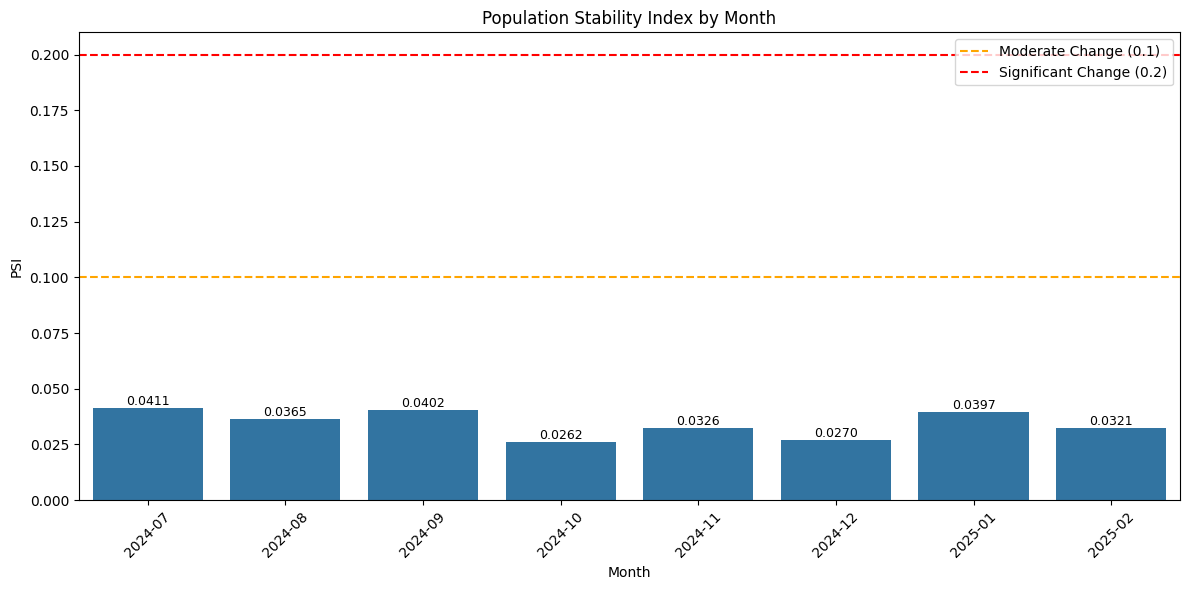

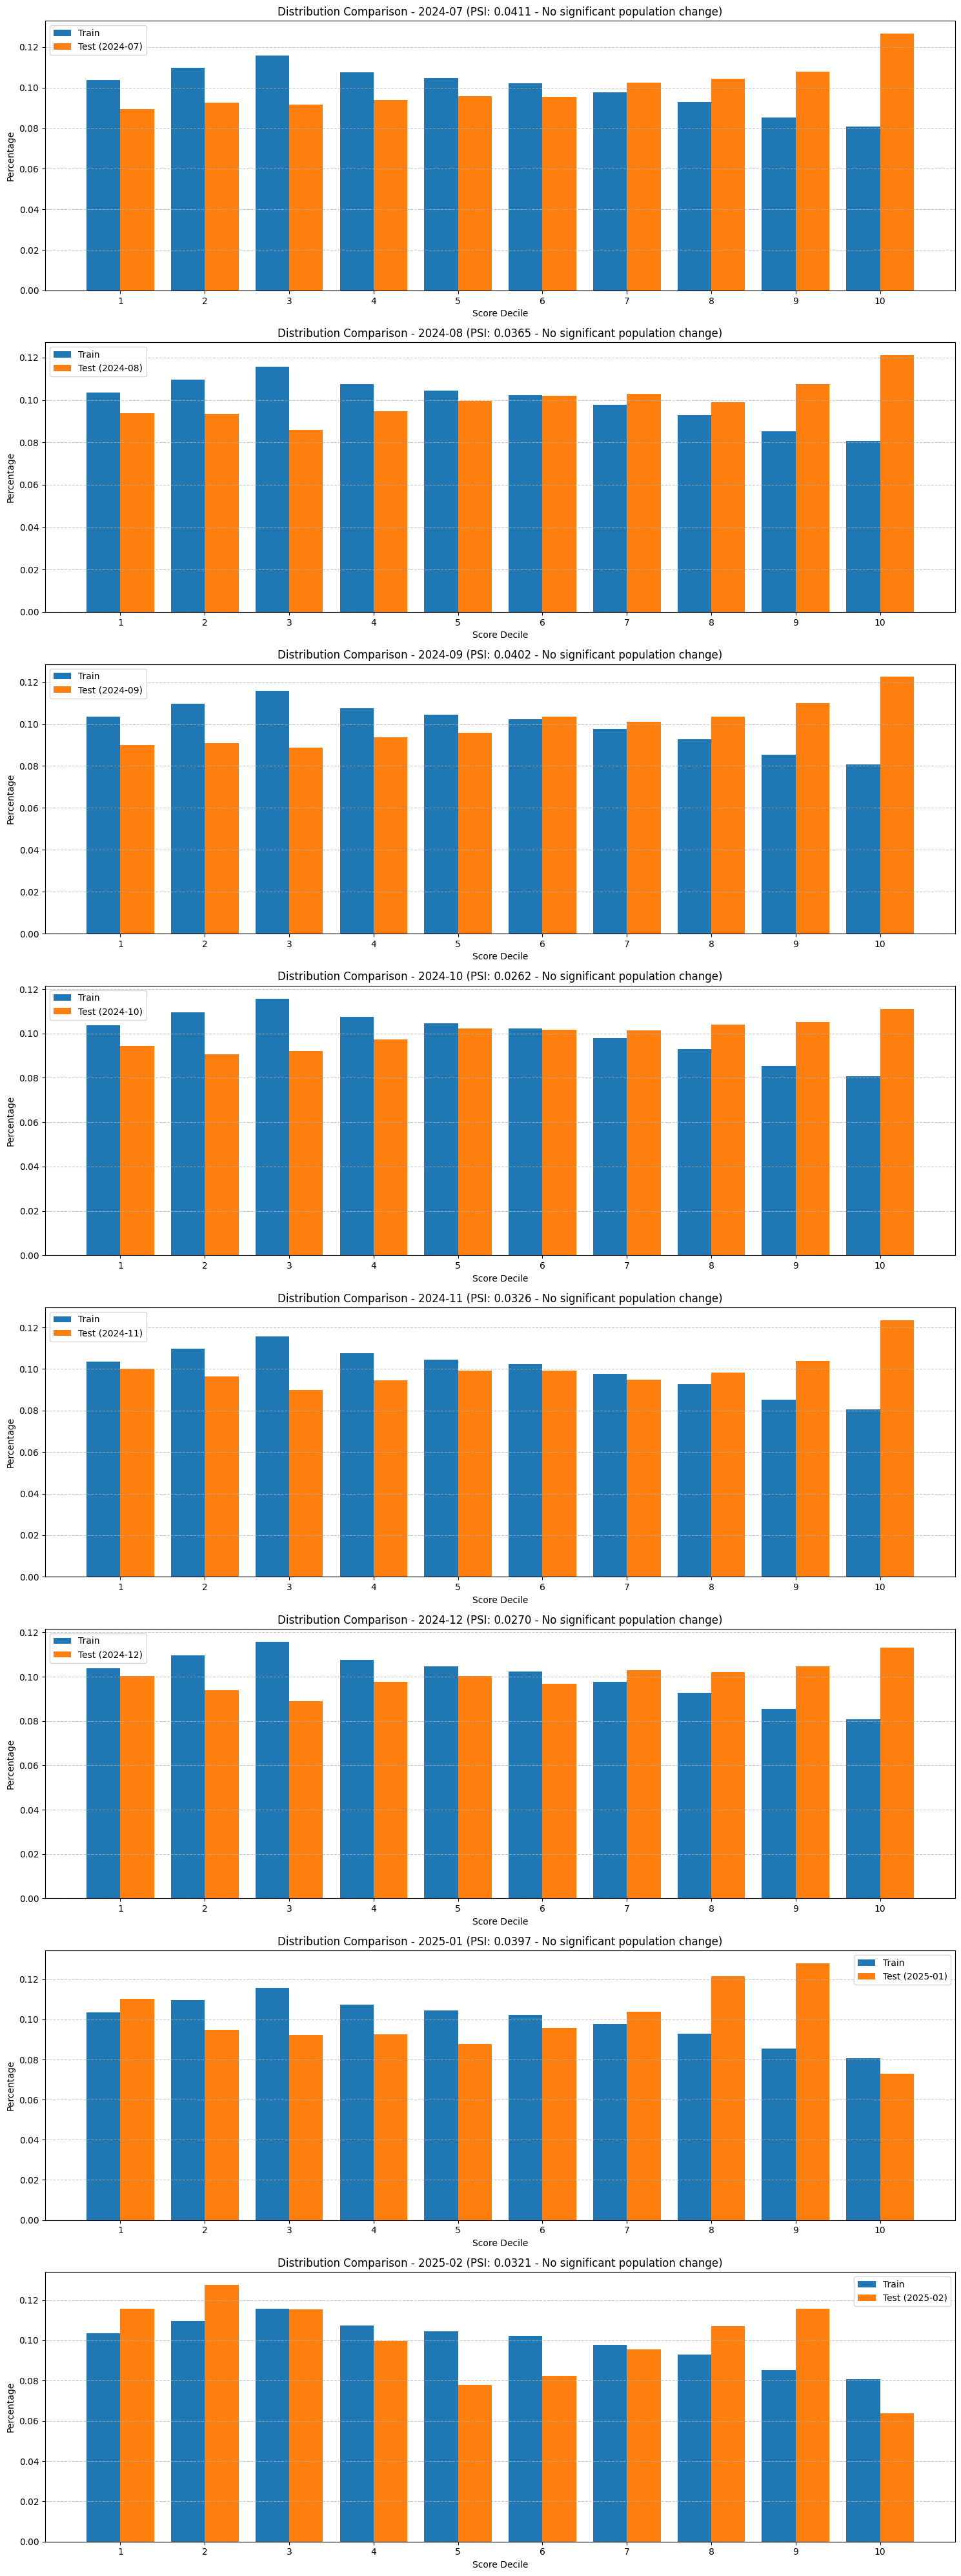

In [10]:
sq = """with base as 
(select 
  a.digitalLoanAccountId, 
  FORMAT_DATE('%Y-%m', a.ln_appln_submit_datetime) Application_month,
  FORMAT_DATE('%F', DATE_TRUNC(a.ln_appln_submit_datetime, WEEK(MONDAY))) as Appl_week_start_date,
  EXTRACT(WEEK(MONDAY) FROM a.ln_appln_submit_datetime) as Appl_week_number,
  NTILE(10) OVER (ORDER BY sa_stack_score) AS sa_stack_score_decile,
  case when date_trunc(a.ln_appln_submit_datetime, day) between '2023-07-01' and '2024-06-30' then 'Train'
       when date_trunc(a.ln_appln_submit_datetime, day) >= '2024-07-01' then 'Test'
       Else 'Other' end dataselection,
  a.sa_stack_score,
 from 
 prj-prod-dataplatform.risk_mart.sil_risk_ds_master_20230101_20250206 a
 where a.ln_loan_applied_flag = 1 and ln_dl_rule_reject_flag = 0
 and date_trunc(a.ln_appln_submit_datetime, day) >= '2023-07-01'
 and sa_stack_score is not null
 )
 select Application_month, Appl_week_start_date , dataselection, sa_stack_score_decile,
 CONCAT(MIN(round(sa_stack_score, 5)), ' - ', MAX(round(sa_stack_score, 5))) AS sa_stack_score_bin_range,
 count(distinct digitalLoanAccountId) app 
 from base where dataselection in ('Train', 'Test') 
 group by 1,2,3,4;"""
 
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')

def calculate_psi(df):
    """
    Calculate Population Stability Index (PSI) between Train set and each month in Test set
    
    Args:
        df: DataFrame with columns 'Application_month', 'dataselection', 'sa_stack_score_decile', 'app'
        
    Returns:
        DataFrame with PSI values for each Test month compared to the entire Train set
    """
    # Convert data to the right types if needed
    if isinstance(df['Application_month'].iloc[0], str):
        df['Application_month'] = pd.to_datetime(df['Application_month']).dt.strftime('%Y-%m')
    
    # Ensure sa_stack_score_decile is an integer
    df['sa_stack_score_decile'] = df['sa_stack_score_decile'].astype(int)
    
    # First, get the distribution for the entire Train set
    train_data = df[df['dataselection'] == 'Train'].copy()
    train_total = train_data['app'].sum()
    
    # Calculate the distribution percentage for each decile in Train set
    train_distribution = train_data.groupby('sa_stack_score_decile')['app'].sum().reset_index()
    train_distribution['percentage'] = train_distribution['app'] / train_total
    
    # Get unique test months
    test_data = df[df['dataselection'] == 'Test'].copy()
    test_months = test_data['Application_month'].unique()
    
    # Create a DataFrame to store PSI results
    psi_results = []
    
    # For each test month, calculate PSI
    for month in test_months:
        month_data = test_data[test_data['Application_month'] == month].copy()
        month_total = month_data['app'].sum()
        
        # Calculate the distribution percentage for each decile in this Test month
        month_distribution = month_data.groupby('sa_stack_score_decile')['app'].sum().reset_index()
        month_distribution['percentage'] = month_distribution['app'] / month_total
        
        # Merge train and month distributions
        comparison = pd.merge(
            train_distribution[['sa_stack_score_decile', 'percentage']], 
            month_distribution[['sa_stack_score_decile', 'percentage']], 
            on='sa_stack_score_decile', 
            how='outer',
            suffixes=('_train', '_test')
        ).fillna(0.0001)  # Replace NaN with small value to avoid division by zero
        
        # PSI calculation: sum((actual - expected) * ln(actual / expected))
        comparison['psi_component'] = (comparison['percentage_test'] - comparison['percentage_train']) * \
                                     np.log(comparison['percentage_test'] / comparison['percentage_train'])
        
        # Total PSI for this month
        month_psi = comparison['psi_component'].sum()
        
        psi_results.append({
            'month': month,
            'psi': month_psi,
            'distribution_comparison': comparison
        })
    
    # Create a summary DataFrame
    psi_summary = pd.DataFrame([{'month': r['month'], 'psi': r['psi']} for r in psi_results])
    
    return psi_summary, psi_results

def interpret_psi(psi_value):
    """Interpret PSI values"""
    if psi_value < 0.1:
        return "No significant population change"
    elif psi_value < 0.2:
        return "Moderate population change"
    else:
        return "Significant population change"

def plot_psi_results(psi_summary):
    """Create a bar chart of PSI values by month"""
    plt.figure(figsize=(12, 6))
    
    # Sort by month
    psi_summary = psi_summary.sort_values('month')
    
    # Create bar chart
    ax = sns.barplot(x='month', y='psi', data=psi_summary)
    
    # Add reference lines
    plt.axhline(y=0.1, color='orange', linestyle='--', label='Moderate Change (0.1)')
    plt.axhline(y=0.2, color='red', linestyle='--', label='Significant Change (0.2)')
    
    # Add labels
    plt.title('Population Stability Index by Month')
    plt.xlabel('Month')
    plt.ylabel('PSI')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # Add PSI values on top of bars
    for i, p in enumerate(ax.patches):
        ax.annotate(f"{p.get_height():.4f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=9)
    
    return plt

def plot_decile_distributions(psi_results):
    """Plot the distribution comparison for each test month"""
    plt.figure(figsize=(15, len(psi_results) * 5))
    
    for i, result in enumerate(sorted(psi_results, key=lambda x: x['month'])):
        plt.subplot(len(psi_results), 1, i+1)
        
        comparison = result['distribution_comparison']
        
        # Convert x to integer numpy array to avoid the float error
        x = comparison['sa_stack_score_decile'].astype(int).values
        
        # Plot train and test distributions
        plt.bar(x - 0.2, comparison['percentage_train'], width=0.4, label='Train')
        plt.bar(x + 0.2, comparison['percentage_test'], width=0.4, label=f'Test ({result["month"]})')
        
        plt.title(f'Distribution Comparison - {result["month"]} (PSI: {result["psi"]:.4f} - {interpret_psi(result["psi"])})')
        plt.xlabel('Score Decile')
        plt.ylabel('Percentage')
        # Use explicit integer ticks to avoid the numpy rounding error
        plt.xticks(x)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return plt

# Example usage
def main(df):
    # Calculate PSI
    psi_summary, psi_results = calculate_psi(df)
    
    # Print summary
    print("Population Stability Index Summary:")
    for _, row in psi_summary.iterrows():
        print(f"Month: {row['month']} - PSI: {row['psi']:.4f} - {interpret_psi(row['psi'])}")
    
    try:
        # Plot results
        plot_psi = plot_psi_results(psi_summary)
        plot_psi.show()
        
        # Plot decile distributions
        plot_dist = plot_decile_distributions(psi_results)
        plot_dist.show()
    except Exception as e:
        print(f"Error during plotting: {e}")
        print("Returning PSI calculations without plots")
    
    return psi_summary, psi_results

# Run the main function
psi_summary, psi_results = main(df)

sa_stack_score_psi_summary = psi_summary.copy()
sa_stack_score_psi_results = psi_results.copy()


In [11]:
sa_stack_score_psi_summary['scorename'] = 'sa_stack_score'
sa_stack_score_psi_summary

month       psi       scorename
0  2024-11  0.032583  sa_stack_score
1  2024-09  0.040220  sa_stack_score
2  2024-08  0.036548  sa_stack_score
3  2024-12  0.026959  sa_stack_score
4  2024-10  0.026248  sa_stack_score
5  2024-07  0.041148  sa_stack_score
6  2025-01  0.039653  sa_stack_score
7  2025-02  0.032147  sa_stack_score

# c_credo_score

Job ID 640b1a15-e91c-4f40-8021-15280fae796a successfully executed: 100%|██████████|

d:\Anaconda3\envs\inc_env\lib\site-packages\google\cloud\bigquery\table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



Downloading: 100%|██████████|
Population Stability Index Summary:
Month: 2025-01 - PSI: 0.0027 - No significant population change
Month: 2024-08 - PSI: 0.0035 - No significant population change
Month: 2024-12 - PSI: 0.0028 - No significant population change
Month: 2024-11 - PSI: 0.0025 - No significant population change
Month: 2024-09 - PSI: 0.0039 - No significant population change
Month: 2024-10 - PSI: 0.0027 - No significant population change
Month: 2024-07 - PSI: 0.0062 - No significant population change
Month: 2025-02 - PSI: 0.0116 - No significant population change


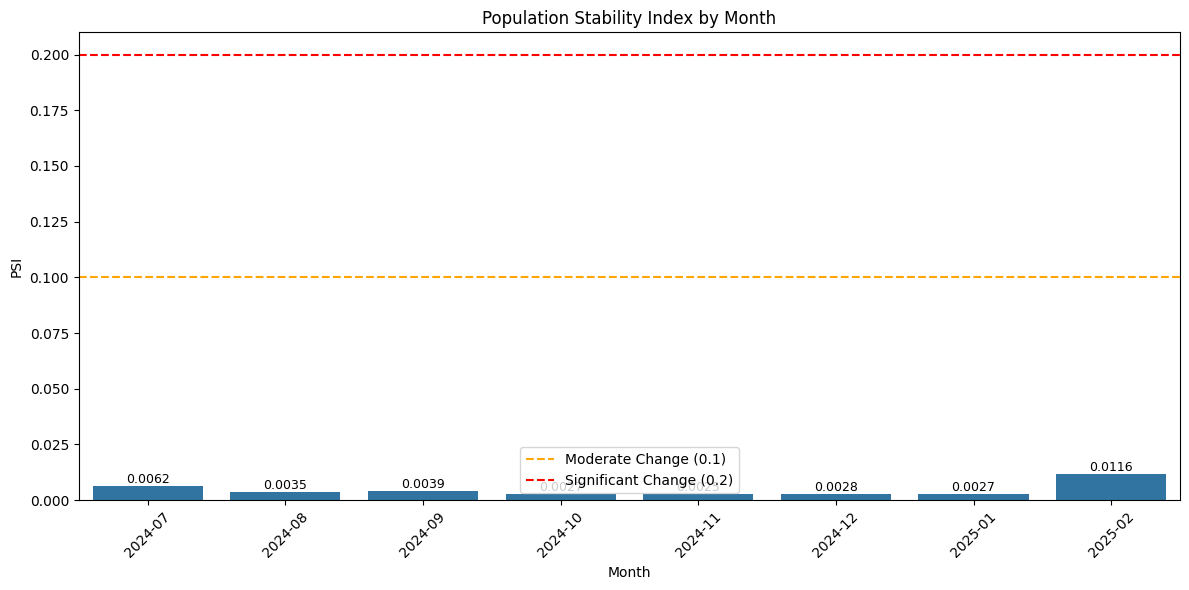

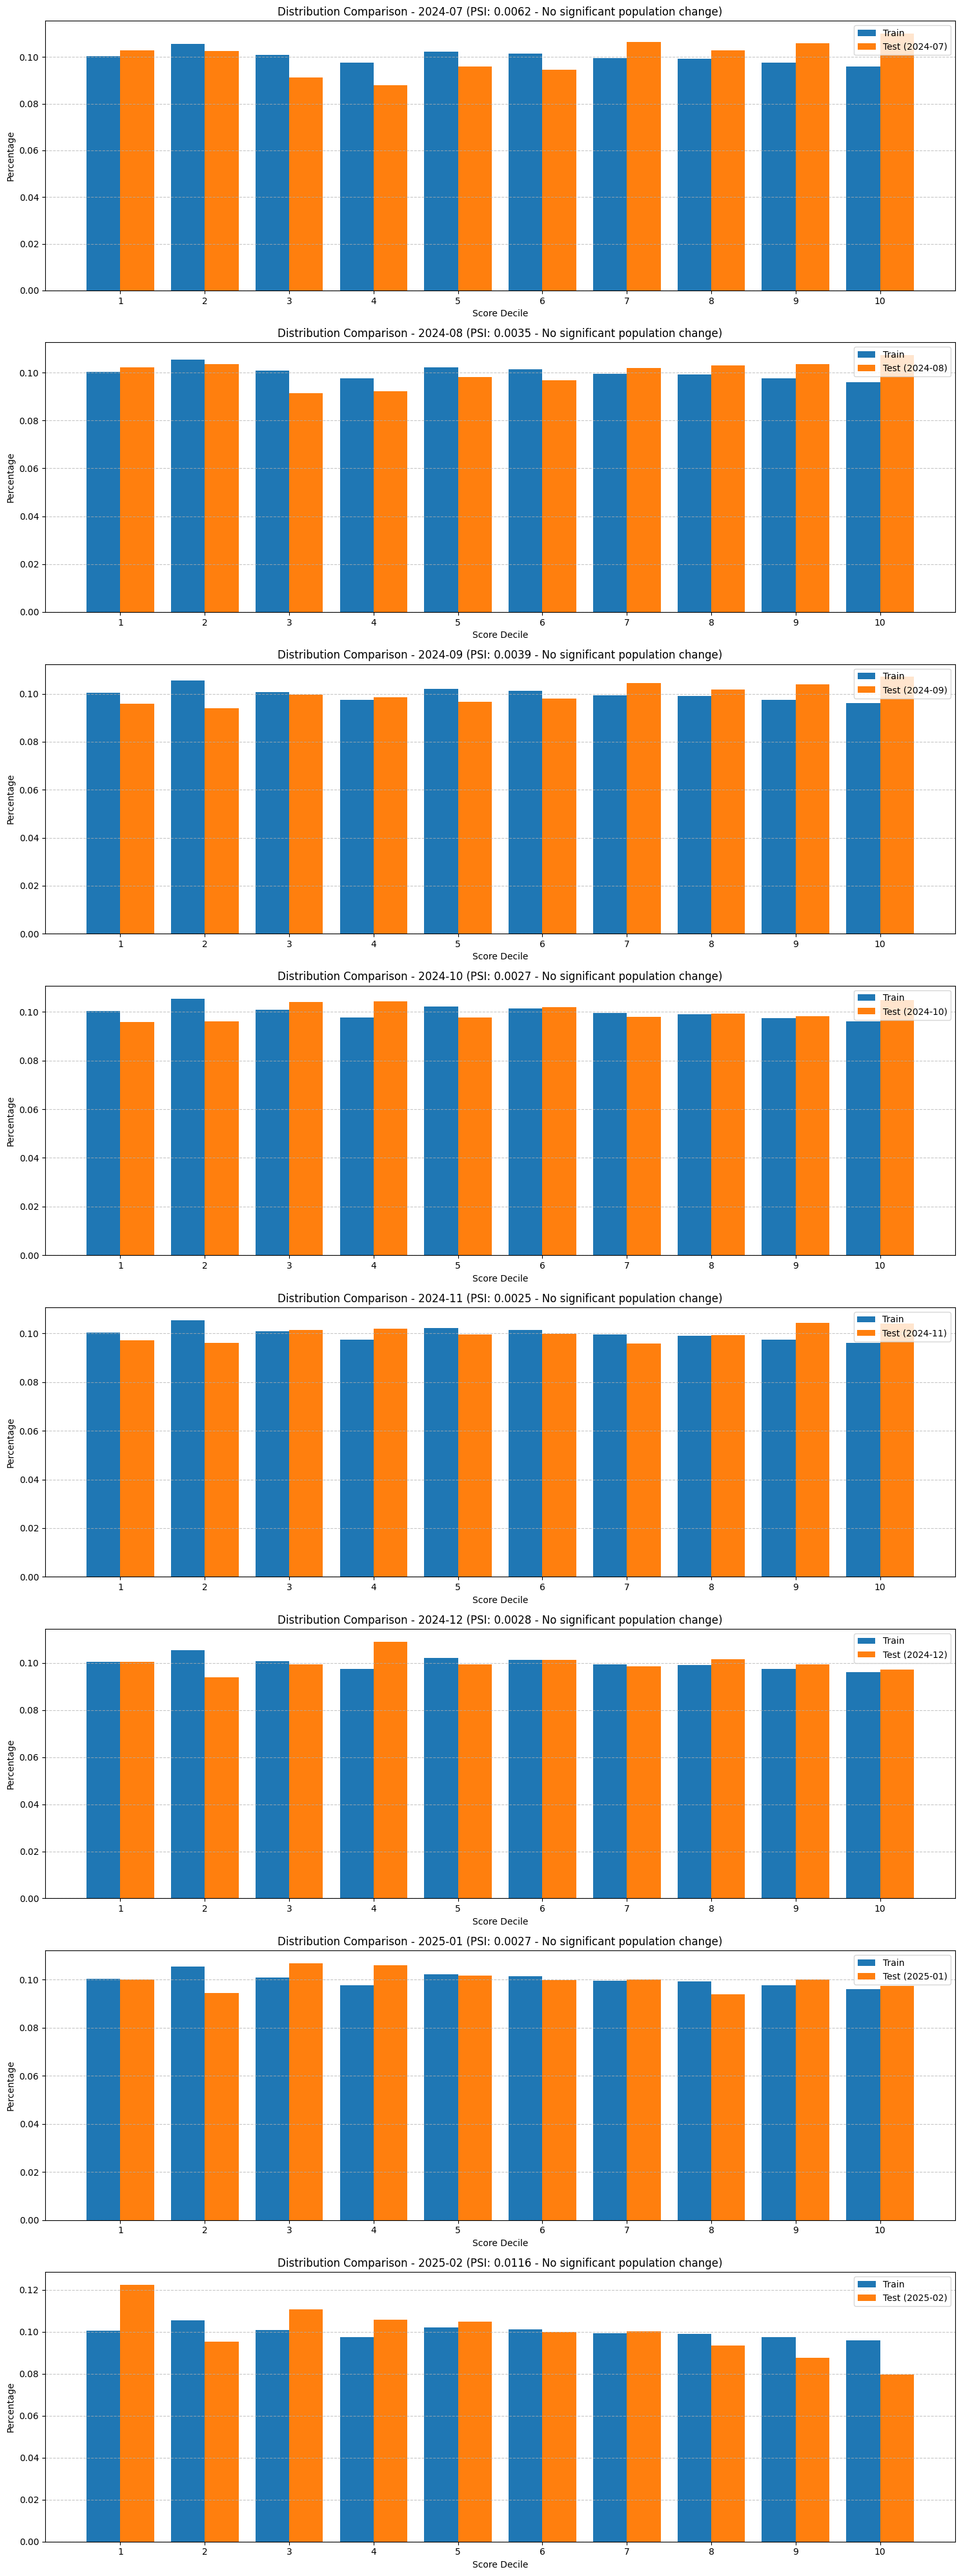

In [12]:
sq = """with base as 
(select 
  a.digitalLoanAccountId, 
  FORMAT_DATE('%Y-%m', a.ln_appln_submit_datetime) Application_month,
  FORMAT_DATE('%F', DATE_TRUNC(a.ln_appln_submit_datetime, WEEK(MONDAY))) as Appl_week_start_date,
  EXTRACT(WEEK(MONDAY) FROM a.ln_appln_submit_datetime) as Appl_week_number,
  NTILE(10) OVER (ORDER BY c_credo_score) AS c_credo_score_decile,
  case when date_trunc(a.ln_appln_submit_datetime, day) between '2023-07-01' and '2024-06-30' then 'Train'
       when date_trunc(a.ln_appln_submit_datetime, day) >= '2024-07-01' then 'Test'
       Else 'Other' end dataselection,
  a.c_credo_score,
 from 
 prj-prod-dataplatform.risk_mart.sil_risk_ds_master_20230101_20250206 a
 where a.ln_loan_applied_flag = 1 and ln_dl_rule_reject_flag = 0
 and date_trunc(a.ln_appln_submit_datetime, day) >= '2023-07-01'
 and c_credo_score is not null
 )
 select Application_month, Appl_week_start_date , dataselection, c_credo_score_decile,
 CONCAT(MIN(round(c_credo_score, 5)), ' - ', MAX(round(c_credo_score, 5))) AS c_credo_score_bin_range,
 count(distinct digitalLoanAccountId) app 
 from base where dataselection in ('Train', 'Test') 
 group by 1,2,3,4;"""
 
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')

def calculate_psi(df):
    """
    Calculate Population Stability Index (PSI) between Train set and each month in Test set
    
    Args:
        df: DataFrame with columns 'Application_month', 'dataselection', 'c_credo_score_decile', 'app'
        
    Returns:
        DataFrame with PSI values for each Test month compared to the entire Train set
    """
    # Convert data to the right types if needed
    if isinstance(df['Application_month'].iloc[0], str):
        df['Application_month'] = pd.to_datetime(df['Application_month']).dt.strftime('%Y-%m')
    
    # Ensure c_credo_score_decile is an integer
    df['c_credo_score_decile'] = df['c_credo_score_decile'].astype(int)
    
    # First, get the distribution for the entire Train set
    train_data = df[df['dataselection'] == 'Train'].copy()
    train_total = train_data['app'].sum()
    
    # Calculate the distribution percentage for each decile in Train set
    train_distribution = train_data.groupby('c_credo_score_decile')['app'].sum().reset_index()
    train_distribution['percentage'] = train_distribution['app'] / train_total
    
    # Get unique test months
    test_data = df[df['dataselection'] == 'Test'].copy()
    test_months = test_data['Application_month'].unique()
    
    # Create a DataFrame to store PSI results
    psi_results = []
    
    # For each test month, calculate PSI
    for month in test_months:
        month_data = test_data[test_data['Application_month'] == month].copy()
        month_total = month_data['app'].sum()
        
        # Calculate the distribution percentage for each decile in this Test month
        month_distribution = month_data.groupby('c_credo_score_decile')['app'].sum().reset_index()
        month_distribution['percentage'] = month_distribution['app'] / month_total
        
        # Merge train and month distributions
        comparison = pd.merge(
            train_distribution[['c_credo_score_decile', 'percentage']], 
            month_distribution[['c_credo_score_decile', 'percentage']], 
            on='c_credo_score_decile', 
            how='outer',
            suffixes=('_train', '_test')
        ).fillna(0.0001)  # Replace NaN with small value to avoid division by zero
        
        # PSI calculation: sum((actual - expected) * ln(actual / expected))
        comparison['psi_component'] = (comparison['percentage_test'] - comparison['percentage_train']) * \
                                     np.log(comparison['percentage_test'] / comparison['percentage_train'])
        
        # Total PSI for this month
        month_psi = comparison['psi_component'].sum()
        
        psi_results.append({
            'month': month,
            'psi': month_psi,
            'distribution_comparison': comparison
        })
    
    # Create a summary DataFrame
    psi_summary = pd.DataFrame([{'month': r['month'], 'psi': r['psi']} for r in psi_results])
    
    return psi_summary, psi_results

def interpret_psi(psi_value):
    """Interpret PSI values"""
    if psi_value < 0.1:
        return "No significant population change"
    elif psi_value < 0.2:
        return "Moderate population change"
    else:
        return "Significant population change"

def plot_psi_results(psi_summary):
    """Create a bar chart of PSI values by month"""
    plt.figure(figsize=(12, 6))
    
    # Sort by month
    psi_summary = psi_summary.sort_values('month')
    
    # Create bar chart
    ax = sns.barplot(x='month', y='psi', data=psi_summary)
    
    # Add reference lines
    plt.axhline(y=0.1, color='orange', linestyle='--', label='Moderate Change (0.1)')
    plt.axhline(y=0.2, color='red', linestyle='--', label='Significant Change (0.2)')
    
    # Add labels
    plt.title('Population Stability Index by Month')
    plt.xlabel('Month')
    plt.ylabel('PSI')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # Add PSI values on top of bars
    for i, p in enumerate(ax.patches):
        ax.annotate(f"{p.get_height():.4f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=9)
    
    return plt

def plot_decile_distributions(psi_results):
    """Plot the distribution comparison for each test month"""
    plt.figure(figsize=(15, len(psi_results) * 5))
    
    for i, result in enumerate(sorted(psi_results, key=lambda x: x['month'])):
        plt.subplot(len(psi_results), 1, i+1)
        
        comparison = result['distribution_comparison']
        
        # Convert x to integer numpy array to avoid the float error
        x = comparison['c_credo_score_decile'].astype(int).values
        
        # Plot train and test distributions
        plt.bar(x - 0.2, comparison['percentage_train'], width=0.4, label='Train')
        plt.bar(x + 0.2, comparison['percentage_test'], width=0.4, label=f'Test ({result["month"]})')
        
        plt.title(f'Distribution Comparison - {result["month"]} (PSI: {result["psi"]:.4f} - {interpret_psi(result["psi"])})')
        plt.xlabel('Score Decile')
        plt.ylabel('Percentage')
        # Use explicit integer ticks to avoid the numpy rounding error
        plt.xticks(x)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return plt

# Example usage
def main(df):
    # Calculate PSI
    psi_summary, psi_results = calculate_psi(df)
    
    # Print summary
    print("Population Stability Index Summary:")
    for _, row in psi_summary.iterrows():
        print(f"Month: {row['month']} - PSI: {row['psi']:.4f} - {interpret_psi(row['psi'])}")
    
    try:
        # Plot results
        plot_psi = plot_psi_results(psi_summary)
        plot_psi.show()
        
        # Plot decile distributions
        plot_dist = plot_decile_distributions(psi_results)
        plot_dist.show()
    except Exception as e:
        print(f"Error during plotting: {e}")
        print("Returning PSI calculations without plots")
    
    return psi_summary, psi_results

# Run the main function
psi_summary, psi_results = main(df)

c_credo_score_psi_summary = psi_summary.copy()
c_credo_score_psi_results = psi_results.copy()


In [13]:
c_credo_score_psi_summary['scorename'] = 'c_credo_score'
c_credo_score_psi_summary

month       psi      scorename
0  2025-01  0.002662  c_credo_score
1  2024-08  0.003514  c_credo_score
2  2024-12  0.002838  c_credo_score
3  2024-11  0.002545  c_credo_score
4  2024-09  0.003894  c_credo_score
5  2024-10  0.002686  c_credo_score
6  2024-07  0.006157  c_credo_score
7  2025-02  0.011563  c_credo_score

# s_credo_score

Job ID f762b52c-9868-4432-91fe-725a04ae487d successfully executed: 100%|██████████|

d:\Anaconda3\envs\inc_env\lib\site-packages\google\cloud\bigquery\table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



Downloading: 100%|██████████|
Population Stability Index Summary:
Month: 2024-08 - PSI: 0.0022 - No significant population change
Month: 2024-11 - PSI: 0.0080 - No significant population change
Month: 2024-12 - PSI: 0.0064 - No significant population change
Month: 2025-01 - PSI: 0.0258 - No significant population change
Month: 2024-10 - PSI: 0.0159 - No significant population change
Month: 2024-09 - PSI: 0.0107 - No significant population change
Month: 2024-07 - PSI: 0.0069 - No significant population change
Month: 2025-02 - PSI: 0.0158 - No significant population change


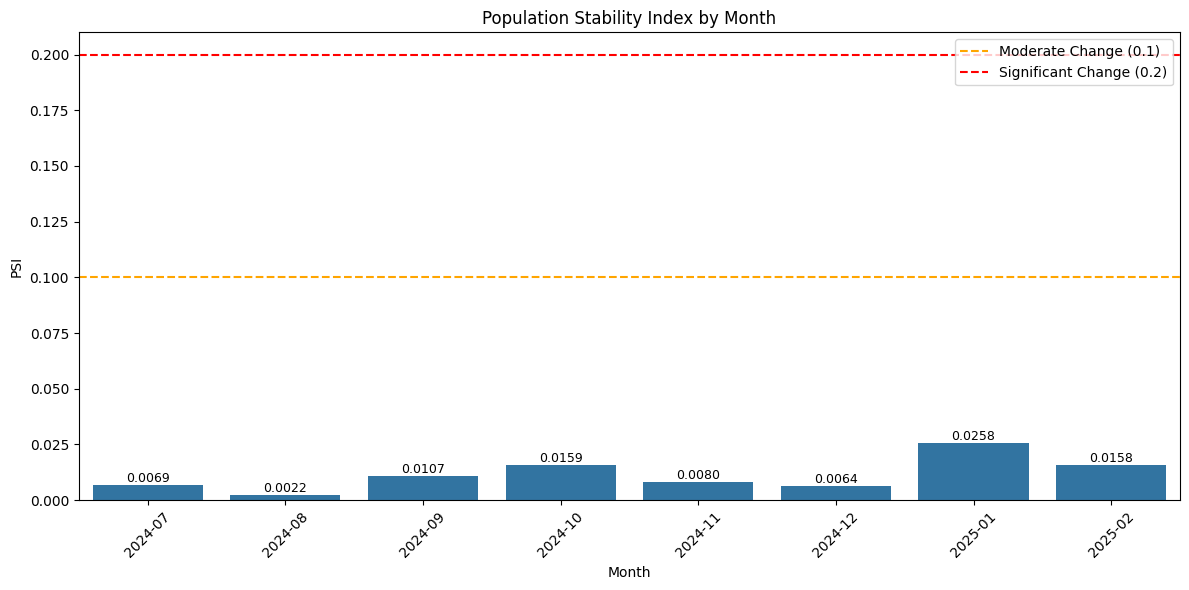

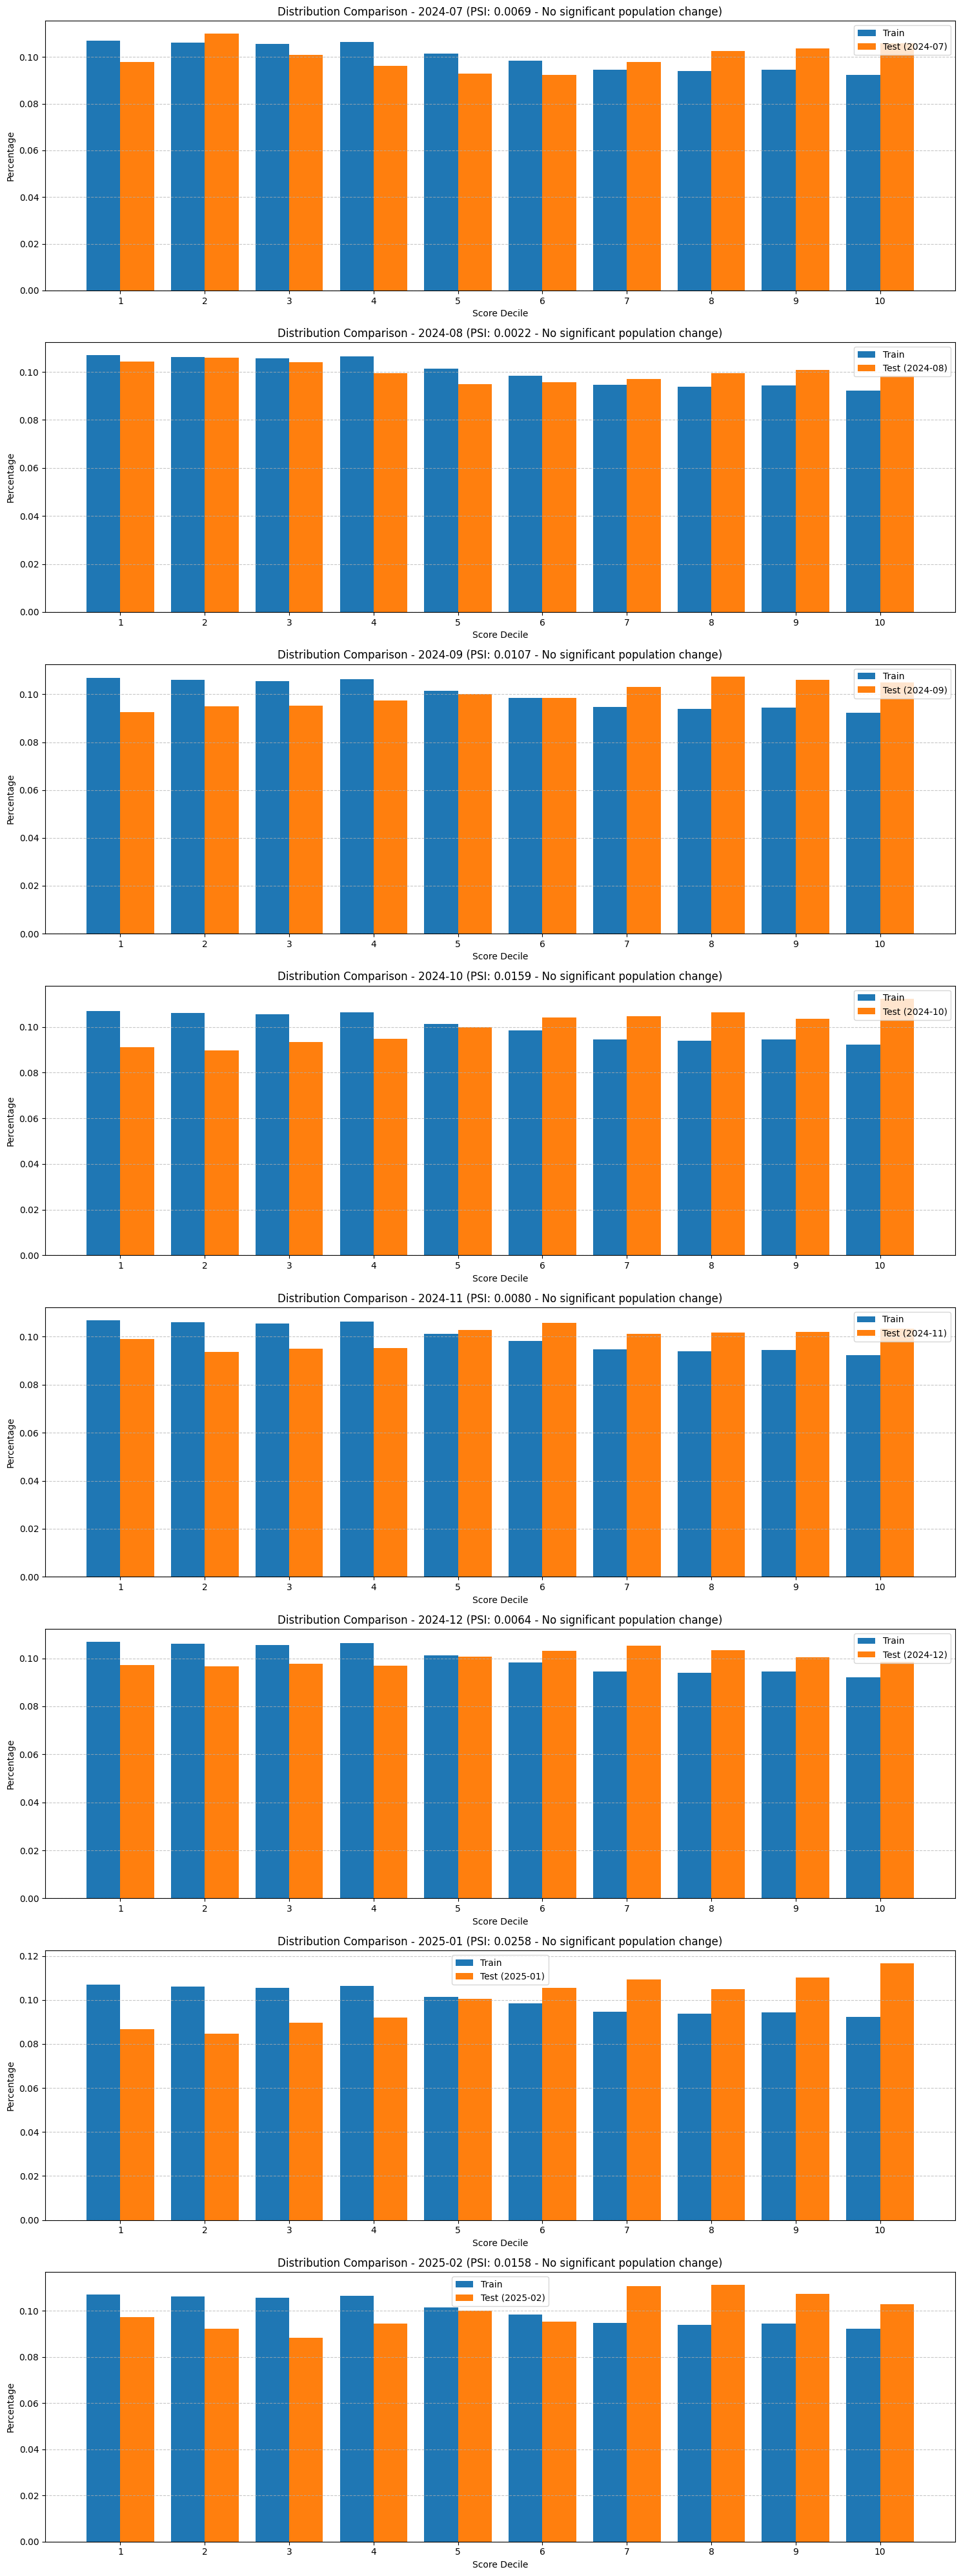

In [14]:
sq = """with base as 
(select 
  a.digitalLoanAccountId, 
  FORMAT_DATE('%Y-%m', a.ln_appln_submit_datetime) Application_month,
  FORMAT_DATE('%F', DATE_TRUNC(a.ln_appln_submit_datetime, WEEK(MONDAY))) as Appl_week_start_date,
  EXTRACT(WEEK(MONDAY) FROM a.ln_appln_submit_datetime) as Appl_week_number,
  NTILE(10) OVER (ORDER BY s_credo_score) AS s_credo_score_decile,
  case when date_trunc(a.ln_appln_submit_datetime, day) between '2023-07-01' and '2024-06-30' then 'Train'
       when date_trunc(a.ln_appln_submit_datetime, day) >= '2024-07-01' then 'Test'
       Else 'Other' end dataselection,
  a.s_credo_score,
 from 
 prj-prod-dataplatform.risk_mart.sil_risk_ds_master_20230101_20250206 a
 where a.ln_loan_applied_flag = 1 and ln_dl_rule_reject_flag = 0
 and date_trunc(a.ln_appln_submit_datetime, day) >= '2023-07-01'
 and s_credo_score is not null
 )
 select Application_month, Appl_week_start_date , dataselection, s_credo_score_decile,
 CONCAT(MIN(round(s_credo_score, 5)), ' - ', MAX(round(s_credo_score, 5))) AS s_credo_score_bin_range,
 count(distinct digitalLoanAccountId) app 
 from base where dataselection in ('Train', 'Test') 
 group by 1,2,3,4;"""
 
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')

def calculate_psi(df):
    """
    Calculate Population Stability Index (PSI) between Train set and each month in Test set
    
    Args:
        df: DataFrame with columns 'Application_month', 'dataselection', 's_credo_score_decile', 'app'
        
    Returns:
        DataFrame with PSI values for each Test month compared to the entire Train set
    """
    # Convert data to the right types if needed
    if isinstance(df['Application_month'].iloc[0], str):
        df['Application_month'] = pd.to_datetime(df['Application_month']).dt.strftime('%Y-%m')
    
    # Ensure s_credo_score_decile is an integer
    df['s_credo_score_decile'] = df['s_credo_score_decile'].astype(int)
    
    # First, get the distribution for the entire Train set
    train_data = df[df['dataselection'] == 'Train'].copy()
    train_total = train_data['app'].sum()
    
    # Calculate the distribution percentage for each decile in Train set
    train_distribution = train_data.groupby('s_credo_score_decile')['app'].sum().reset_index()
    train_distribution['percentage'] = train_distribution['app'] / train_total
    
    # Get unique test months
    test_data = df[df['dataselection'] == 'Test'].copy()
    test_months = test_data['Application_month'].unique()
    
    # Create a DataFrame to store PSI results
    psi_results = []
    
    # For each test month, calculate PSI
    for month in test_months:
        month_data = test_data[test_data['Application_month'] == month].copy()
        month_total = month_data['app'].sum()
        
        # Calculate the distribution percentage for each decile in this Test month
        month_distribution = month_data.groupby('s_credo_score_decile')['app'].sum().reset_index()
        month_distribution['percentage'] = month_distribution['app'] / month_total
        
        # Merge train and month distributions
        comparison = pd.merge(
            train_distribution[['s_credo_score_decile', 'percentage']], 
            month_distribution[['s_credo_score_decile', 'percentage']], 
            on='s_credo_score_decile', 
            how='outer',
            suffixes=('_train', '_test')
        ).fillna(0.0001)  # Replace NaN with small value to avoid division by zero
        
        # PSI calculation: sum((actual - expected) * ln(actual / expected))
        comparison['psi_component'] = (comparison['percentage_test'] - comparison['percentage_train']) * \
                                     np.log(comparison['percentage_test'] / comparison['percentage_train'])
        
        # Total PSI for this month
        month_psi = comparison['psi_component'].sum()
        
        psi_results.append({
            'month': month,
            'psi': month_psi,
            'distribution_comparison': comparison
        })
    
    # Create a summary DataFrame
    psi_summary = pd.DataFrame([{'month': r['month'], 'psi': r['psi']} for r in psi_results])
    
    return psi_summary, psi_results

def interpret_psi(psi_value):
    """Interpret PSI values"""
    if psi_value < 0.1:
        return "No significant population change"
    elif psi_value < 0.2:
        return "Moderate population change"
    else:
        return "Significant population change"

def plot_psi_results(psi_summary):
    """Create a bar chart of PSI values by month"""
    plt.figure(figsize=(12, 6))
    
    # Sort by month
    psi_summary = psi_summary.sort_values('month')
    
    # Create bar chart
    ax = sns.barplot(x='month', y='psi', data=psi_summary)
    
    # Add reference lines
    plt.axhline(y=0.1, color='orange', linestyle='--', label='Moderate Change (0.1)')
    plt.axhline(y=0.2, color='red', linestyle='--', label='Significant Change (0.2)')
    
    # Add labels
    plt.title('Population Stability Index by Month')
    plt.xlabel('Month')
    plt.ylabel('PSI')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # Add PSI values on top of bars
    for i, p in enumerate(ax.patches):
        ax.annotate(f"{p.get_height():.4f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=9)
    
    return plt

def plot_decile_distributions(psi_results):
    """Plot the distribution comparison for each test month"""
    plt.figure(figsize=(15, len(psi_results) * 5))
    
    for i, result in enumerate(sorted(psi_results, key=lambda x: x['month'])):
        plt.subplot(len(psi_results), 1, i+1)
        
        comparison = result['distribution_comparison']
        
        # Convert x to integer numpy array to avoid the float error
        x = comparison['s_credo_score_decile'].astype(int).values
        
        # Plot train and test distributions
        plt.bar(x - 0.2, comparison['percentage_train'], width=0.4, label='Train')
        plt.bar(x + 0.2, comparison['percentage_test'], width=0.4, label=f'Test ({result["month"]})')
        
        plt.title(f'Distribution Comparison - {result["month"]} (PSI: {result["psi"]:.4f} - {interpret_psi(result["psi"])})')
        plt.xlabel('Score Decile')
        plt.ylabel('Percentage')
        # Use explicit integer ticks to avoid the numpy rounding error
        plt.xticks(x)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return plt

# Example usage
def main(df):
    # Calculate PSI
    psi_summary, psi_results = calculate_psi(df)
    
    # Print summary
    print("Population Stability Index Summary:")
    for _, row in psi_summary.iterrows():
        print(f"Month: {row['month']} - PSI: {row['psi']:.4f} - {interpret_psi(row['psi'])}")
    
    try:
        # Plot results
        plot_psi = plot_psi_results(psi_summary)
        plot_psi.show()
        
        # Plot decile distributions
        plot_dist = plot_decile_distributions(psi_results)
        plot_dist.show()
    except Exception as e:
        print(f"Error during plotting: {e}")
        print("Returning PSI calculations without plots")
    
    return psi_summary, psi_results

# Run the main function
psi_summary, psi_results = main(df)

s_credo_score_psi_summary = psi_summary.copy()
s_credo_score_psi_results = psi_results.copy()


In [15]:
s_credo_score_psi_summary['scorename'] = 's_credo_score'
s_credo_score_psi_summary

month       psi      scorename
0  2024-08  0.002247  s_credo_score
1  2024-11  0.008043  s_credo_score
2  2024-12  0.006358  s_credo_score
3  2025-01  0.025757  s_credo_score
4  2024-10  0.015934  s_credo_score
5  2024-09  0.010711  s_credo_score
6  2024-07  0.006862  s_credo_score
7  2025-02  0.015783  s_credo_score

# fu_credo_score

Job ID aea8025c-9d1b-4b97-b55b-dd931f959d65 successfully executed: 100%|██████████|

d:\Anaconda3\envs\inc_env\lib\site-packages\google\cloud\bigquery\table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



Downloading: 100%|██████████|
Population Stability Index Summary:
Month: 2024-11 - PSI: 0.0144 - No significant population change
Month: 2024-07 - PSI: 0.0053 - No significant population change
Month: 2024-12 - PSI: 0.0123 - No significant population change
Month: 2024-09 - PSI: 0.0098 - No significant population change
Month: 2024-10 - PSI: 0.0182 - No significant population change
Month: 2025-02 - PSI: 0.0081 - No significant population change
Month: 2024-08 - PSI: 0.0054 - No significant population change
Month: 2025-01 - PSI: 0.0059 - No significant population change


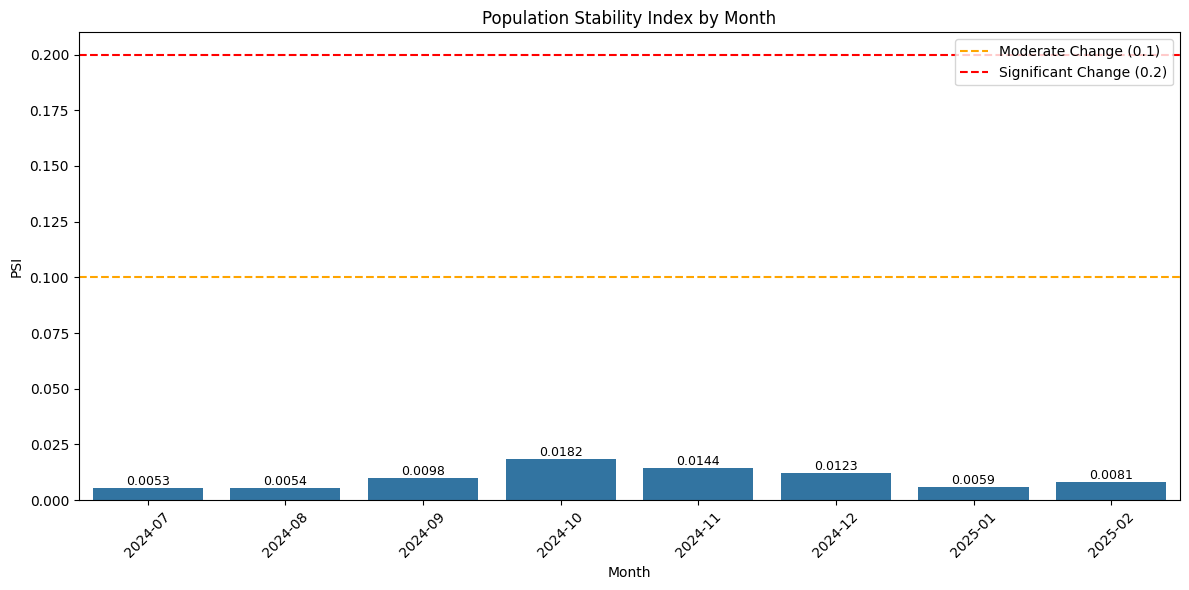

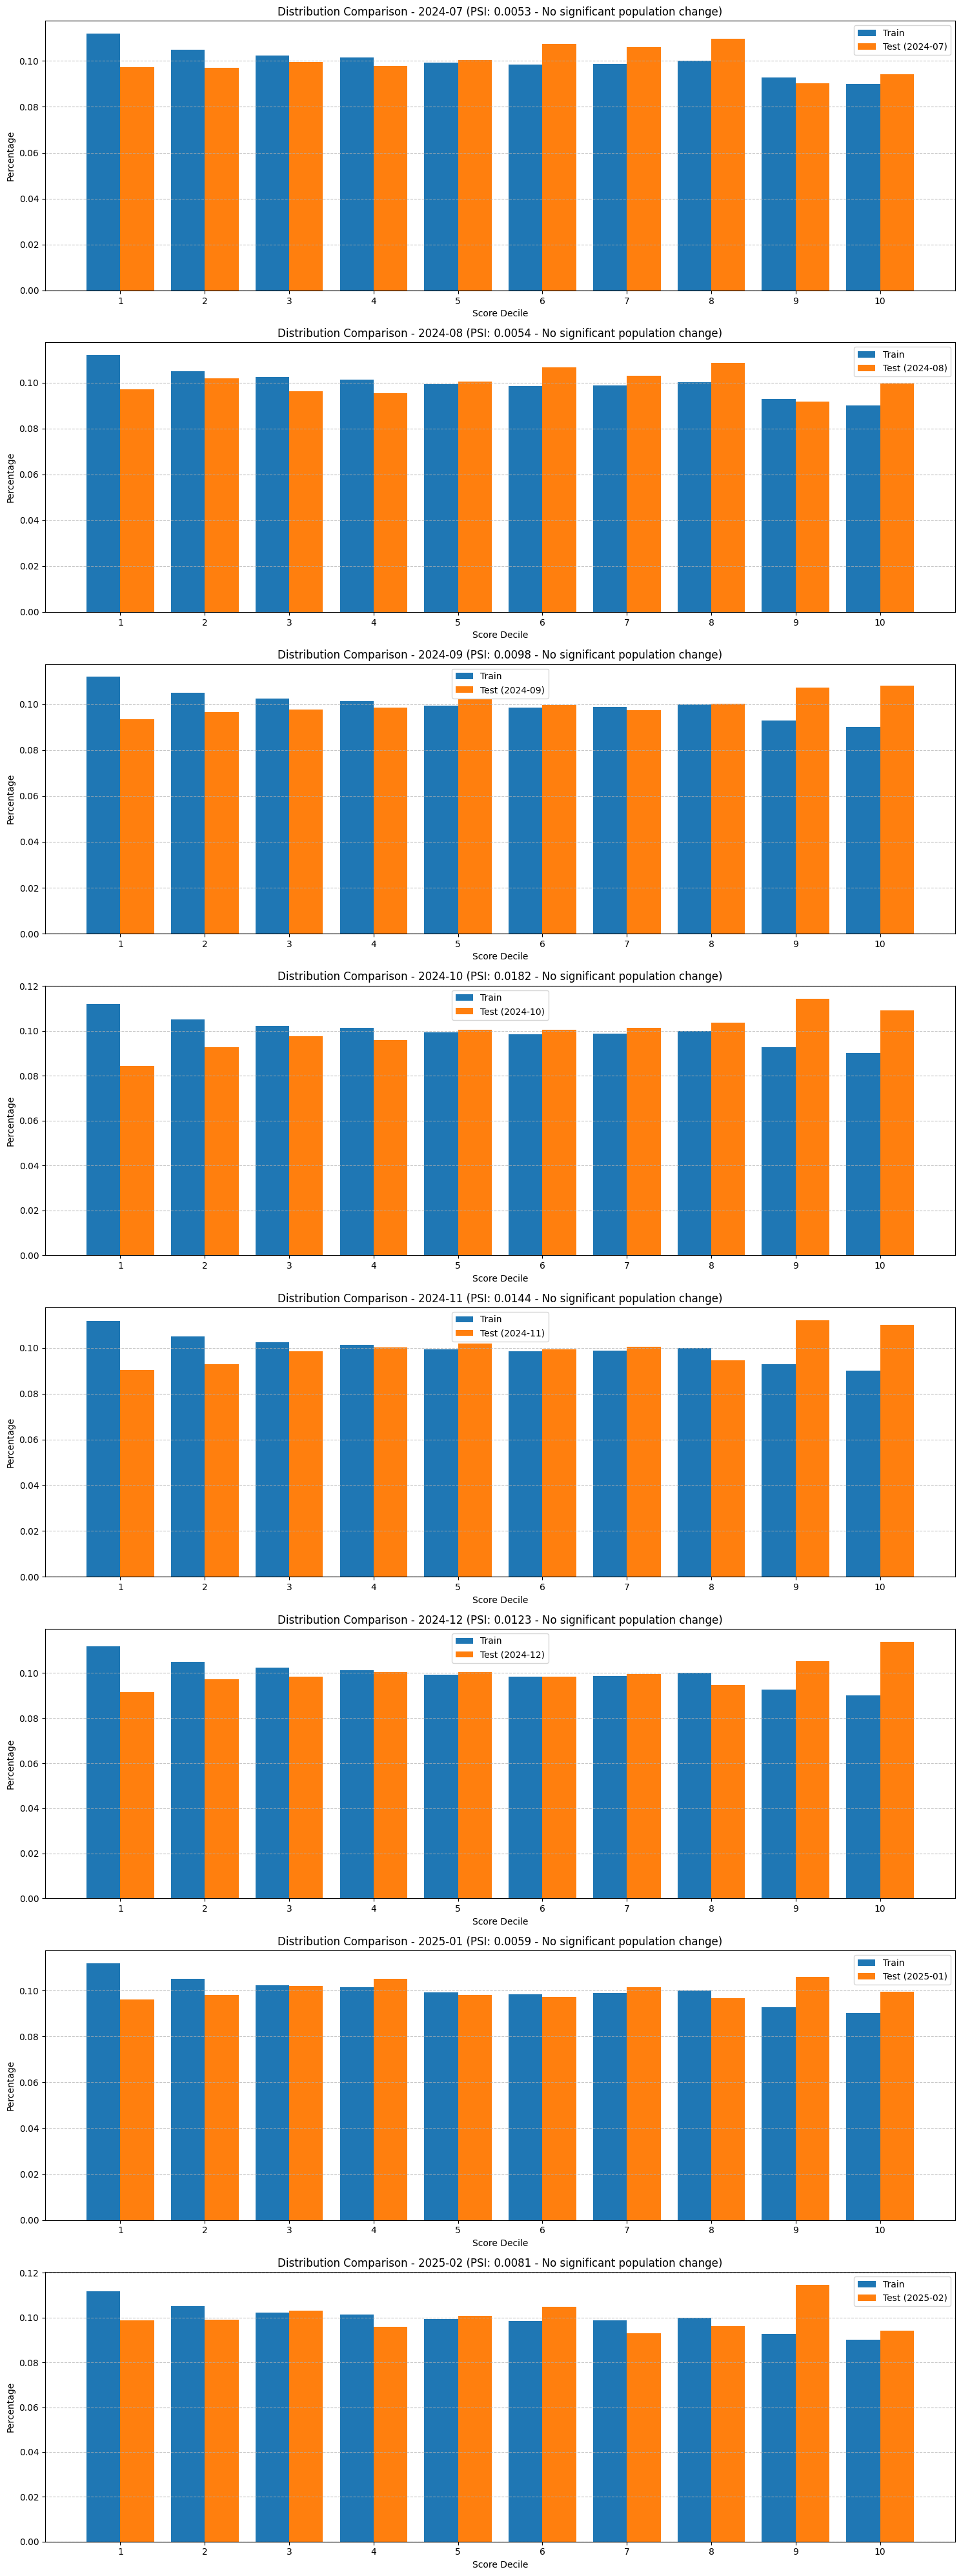

In [16]:
sq = """with base as 
(select 
  a.digitalLoanAccountId, 
  FORMAT_DATE('%Y-%m', a.ln_appln_submit_datetime) Application_month,
  FORMAT_DATE('%F', DATE_TRUNC(a.ln_appln_submit_datetime, WEEK(MONDAY))) as Appl_week_start_date,
  EXTRACT(WEEK(MONDAY) FROM a.ln_appln_submit_datetime) as Appl_week_number,
  NTILE(10) OVER (ORDER BY fu_credo_score) AS fu_credo_score_decile,
  case when date_trunc(a.ln_appln_submit_datetime, day) between '2023-07-01' and '2024-06-30' then 'Train'
       when date_trunc(a.ln_appln_submit_datetime, day) >= '2024-07-01' then 'Test'
       Else 'Other' end dataselection,
  a.fu_credo_score,
 from 
 prj-prod-dataplatform.risk_mart.sil_risk_ds_master_20230101_20250206 a
 where a.ln_loan_applied_flag = 1 and ln_dl_rule_reject_flag = 0
 and date_trunc(a.ln_appln_submit_datetime, day) >= '2023-07-01'
 and fu_credo_score is not null
 )
 select Application_month, Appl_week_start_date , dataselection, fu_credo_score_decile,
 CONCAT(MIN(round(fu_credo_score, 5)), ' - ', MAX(round(fu_credo_score, 5))) AS fu_credo_score_bin_range,
 count(distinct digitalLoanAccountId) app 
 from base where dataselection in ('Train', 'Test') 
 group by 1,2,3,4;"""
 
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')

def calculate_psi(df):
    """
    Calculate Population Stability Index (PSI) between Train set and each month in Test set
    
    Args:
        df: DataFrame with columns 'Application_month', 'dataselection', 'fu_credo_score_decile', 'app'
        
    Returns:
        DataFrame with PSI values for each Test month compared to the entire Train set
    """
    # Convert data to the right types if needed
    if isinstance(df['Application_month'].iloc[0], str):
        df['Application_month'] = pd.to_datetime(df['Application_month']).dt.strftime('%Y-%m')
    
    # Ensure fu_credo_score_decile is an integer
    df['fu_credo_score_decile'] = df['fu_credo_score_decile'].astype(int)
    
    # First, get the distribution for the entire Train set
    train_data = df[df['dataselection'] == 'Train'].copy()
    train_total = train_data['app'].sum()
    
    # Calculate the distribution percentage for each decile in Train set
    train_distribution = train_data.groupby('fu_credo_score_decile')['app'].sum().reset_index()
    train_distribution['percentage'] = train_distribution['app'] / train_total
    
    # Get unique test months
    test_data = df[df['dataselection'] == 'Test'].copy()
    test_months = test_data['Application_month'].unique()
    
    # Create a DataFrame to store PSI results
    psi_results = []
    
    # For each test month, calculate PSI
    for month in test_months:
        month_data = test_data[test_data['Application_month'] == month].copy()
        month_total = month_data['app'].sum()
        
        # Calculate the distribution percentage for each decile in this Test month
        month_distribution = month_data.groupby('fu_credo_score_decile')['app'].sum().reset_index()
        month_distribution['percentage'] = month_distribution['app'] / month_total
        
        # Merge train and month distributions
        comparison = pd.merge(
            train_distribution[['fu_credo_score_decile', 'percentage']], 
            month_distribution[['fu_credo_score_decile', 'percentage']], 
            on='fu_credo_score_decile', 
            how='outer',
            suffixes=('_train', '_test')
        ).fillna(0.0001)  # Replace NaN with small value to avoid division by zero
        
        # PSI calculation: sum((actual - expected) * ln(actual / expected))
        comparison['psi_component'] = (comparison['percentage_test'] - comparison['percentage_train']) * \
                                     np.log(comparison['percentage_test'] / comparison['percentage_train'])
        
        # Total PSI for this month
        month_psi = comparison['psi_component'].sum()
        
        psi_results.append({
            'month': month,
            'psi': month_psi,
            'distribution_comparison': comparison
        })
    
    # Create a summary DataFrame
    psi_summary = pd.DataFrame([{'month': r['month'], 'psi': r['psi']} for r in psi_results])
    
    return psi_summary, psi_results

def interpret_psi(psi_value):
    """Interpret PSI values"""
    if psi_value < 0.1:
        return "No significant population change"
    elif psi_value < 0.2:
        return "Moderate population change"
    else:
        return "Significant population change"

def plot_psi_results(psi_summary):
    """Create a bar chart of PSI values by month"""
    plt.figure(figsize=(12, 6))
    
    # Sort by month
    psi_summary = psi_summary.sort_values('month')
    
    # Create bar chart
    ax = sns.barplot(x='month', y='psi', data=psi_summary)
    
    # Add reference lines
    plt.axhline(y=0.1, color='orange', linestyle='--', label='Moderate Change (0.1)')
    plt.axhline(y=0.2, color='red', linestyle='--', label='Significant Change (0.2)')
    
    # Add labels
    plt.title('Population Stability Index by Month')
    plt.xlabel('Month')
    plt.ylabel('PSI')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # Add PSI values on top of bars
    for i, p in enumerate(ax.patches):
        ax.annotate(f"{p.get_height():.4f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=9)
    
    return plt

def plot_decile_distributions(psi_results):
    """Plot the distribution comparison for each test month"""
    plt.figure(figsize=(15, len(psi_results) * 5))
    
    for i, result in enumerate(sorted(psi_results, key=lambda x: x['month'])):
        plt.subplot(len(psi_results), 1, i+1)
        
        comparison = result['distribution_comparison']
        
        # Convert x to integer numpy array to avoid the float error
        x = comparison['fu_credo_score_decile'].astype(int).values
        
        # Plot train and test distributions
        plt.bar(x - 0.2, comparison['percentage_train'], width=0.4, label='Train')
        plt.bar(x + 0.2, comparison['percentage_test'], width=0.4, label=f'Test ({result["month"]})')
        
        plt.title(f'Distribution Comparison - {result["month"]} (PSI: {result["psi"]:.4f} - {interpret_psi(result["psi"])})')
        plt.xlabel('Score Decile')
        plt.ylabel('Percentage')
        # Use explicit integer ticks to avoid the numpy rounding error
        plt.xticks(x)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return plt

# Example usage
def main(df):
    # Calculate PSI
    psi_summary, psi_results = calculate_psi(df)
    
    # Print summary
    print("Population Stability Index Summary:")
    for _, row in psi_summary.iterrows():
        print(f"Month: {row['month']} - PSI: {row['psi']:.4f} - {interpret_psi(row['psi'])}")
    
    try:
        # Plot results
        plot_psi = plot_psi_results(psi_summary)
        plot_psi.show()
        
        # Plot decile distributions
        plot_dist = plot_decile_distributions(psi_results)
        plot_dist.show()
    except Exception as e:
        print(f"Error during plotting: {e}")
        print("Returning PSI calculations without plots")
    
    return psi_summary, psi_results

# Run the main function
psi_summary, psi_results = main(df)

fu_credo_score_psi_summary = psi_summary.copy()
fu_credo_score_psi_results = psi_results.copy()


In [17]:
fu_credo_score_psi_summary['scorename'] = 'fu_credo_score'
fu_credo_score_psi_summary

month       psi       scorename
0  2024-11  0.014379  fu_credo_score
1  2024-07  0.005265  fu_credo_score
2  2024-12  0.012347  fu_credo_score
3  2024-09  0.009794  fu_credo_score
4  2024-10  0.018246  fu_credo_score
5  2025-02  0.008063  fu_credo_score
6  2024-08  0.005386  fu_credo_score
7  2025-01  0.005886  fu_credo_score

# r_credo_score

Job ID a802f382-2c9a-489c-b22a-665cb3004497 successfully executed: 100%|██████████|

d:\Anaconda3\envs\inc_env\lib\site-packages\google\cloud\bigquery\table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



Downloading: 100%|██████████|
Population Stability Index Summary:
Month: 2024-12 - PSI: 0.0030 - No significant population change
Month: 2024-09 - PSI: 0.0044 - No significant population change
Month: 2024-07 - PSI: 0.0107 - No significant population change
Month: 2025-01 - PSI: 0.0118 - No significant population change
Month: 2024-11 - PSI: 0.0029 - No significant population change
Month: 2025-02 - PSI: 0.0076 - No significant population change
Month: 2024-08 - PSI: 0.0081 - No significant population change
Month: 2024-10 - PSI: 0.0062 - No significant population change


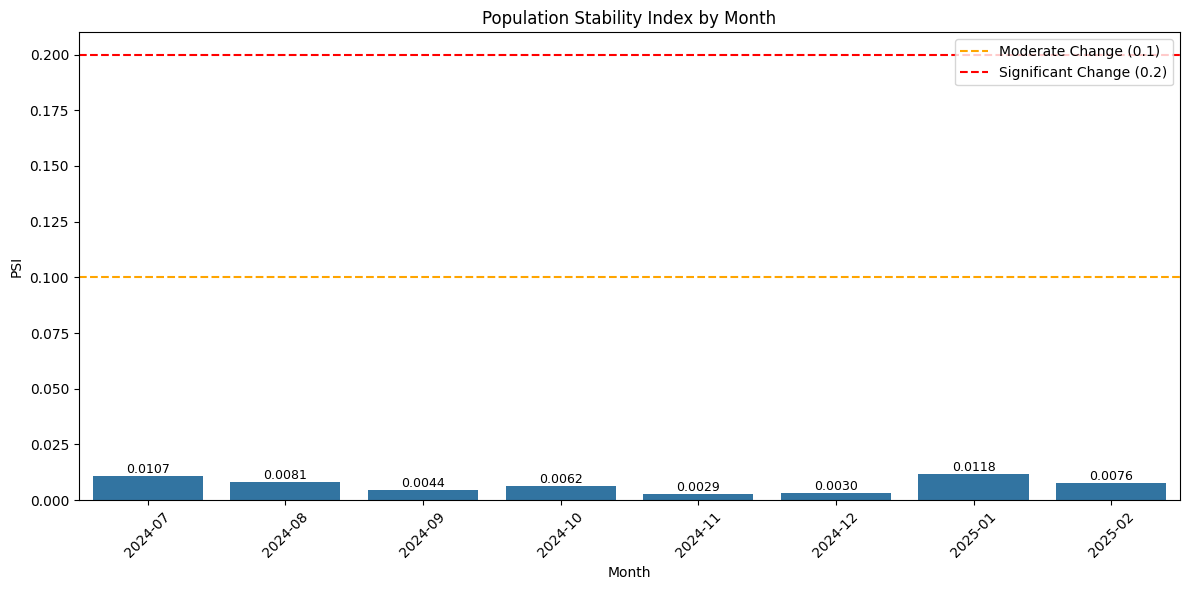

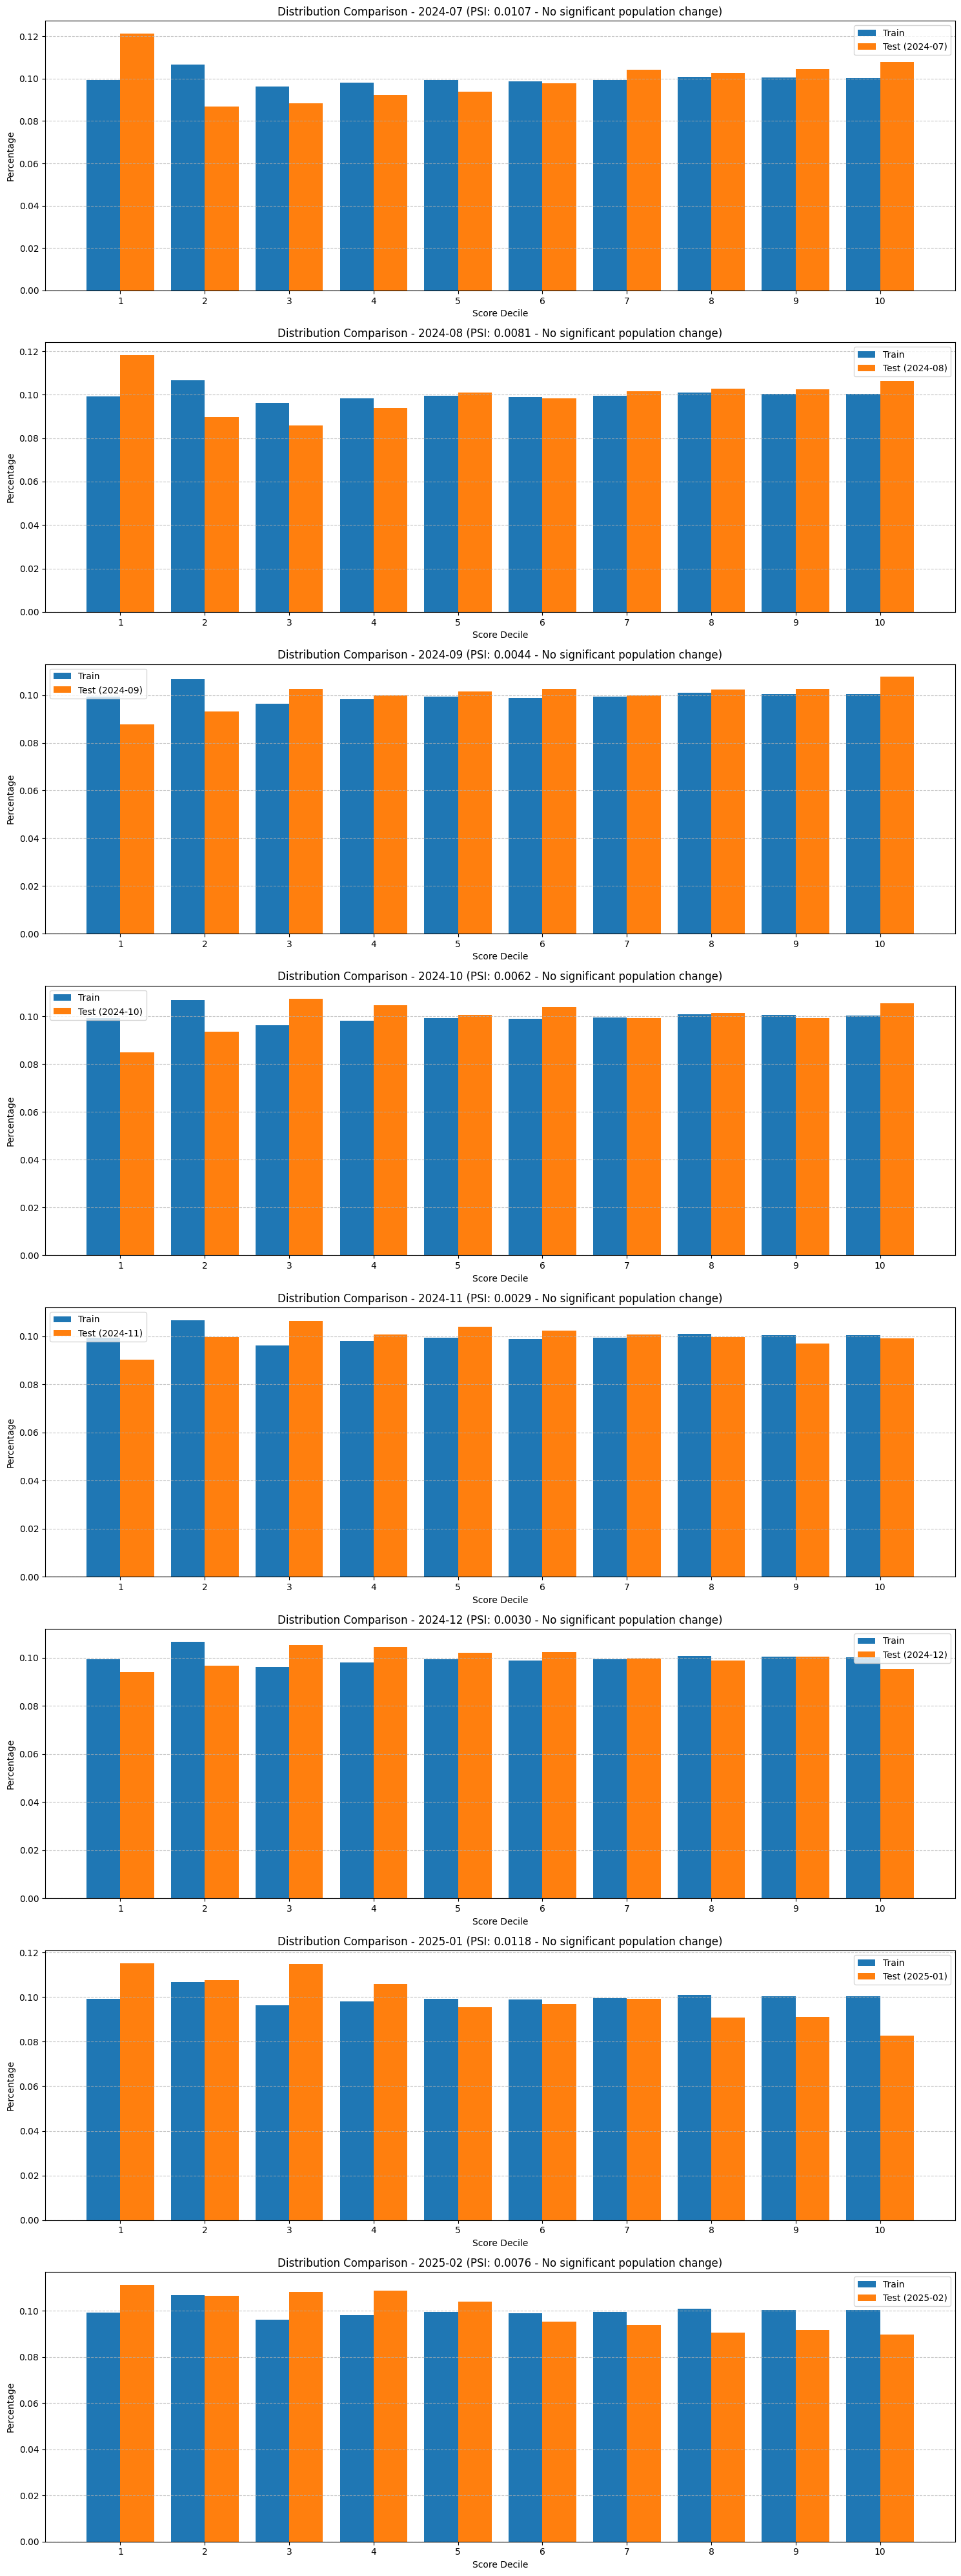

In [18]:
sq = """with base as 
(select 
  a.digitalLoanAccountId, 
  FORMAT_DATE('%Y-%m', a.ln_appln_submit_datetime) Application_month,
  FORMAT_DATE('%F', DATE_TRUNC(a.ln_appln_submit_datetime, WEEK(MONDAY))) as Appl_week_start_date,
  EXTRACT(WEEK(MONDAY) FROM a.ln_appln_submit_datetime) as Appl_week_number,
  NTILE(10) OVER (ORDER BY r_credo_score) AS r_credo_score_decile,
  case when date_trunc(a.ln_appln_submit_datetime, day) between '2023-07-01' and '2024-06-30' then 'Train'
       when date_trunc(a.ln_appln_submit_datetime, day) >= '2024-07-01' then 'Test'
       Else 'Other' end dataselection,
  a.r_credo_score,
 from 
 prj-prod-dataplatform.risk_mart.sil_risk_ds_master_20230101_20250206 a
 where a.ln_loan_applied_flag = 1 and ln_dl_rule_reject_flag = 0
 and date_trunc(a.ln_appln_submit_datetime, day) >= '2023-07-01'
 and r_credo_score is not null
 )
 select Application_month, Appl_week_start_date , dataselection, r_credo_score_decile,
 CONCAT(MIN(round(r_credo_score, 5)), ' - ', MAX(round(r_credo_score, 5))) AS r_credo_score_bin_range,
 count(distinct digitalLoanAccountId) app 
 from base where dataselection in ('Train', 'Test') 
 group by 1,2,3,4;"""
 
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')

def calculate_psi(df):
    """
    Calculate Population Stability Index (PSI) between Train set and each month in Test set
    
    Args:
        df: DataFrame with columns 'Application_month', 'dataselection', 'r_credo_score_decile', 'app'
        
    Returns:
        DataFrame with PSI values for each Test month compared to the entire Train set
    """
    # Convert data to the right types if needed
    if isinstance(df['Application_month'].iloc[0], str):
        df['Application_month'] = pd.to_datetime(df['Application_month']).dt.strftime('%Y-%m')
    
    # Ensure r_credo_score_decile is an integer
    df['r_credo_score_decile'] = df['r_credo_score_decile'].astype(int)
    
    # First, get the distribution for the entire Train set
    train_data = df[df['dataselection'] == 'Train'].copy()
    train_total = train_data['app'].sum()
    
    # Calculate the distribution percentage for each decile in Train set
    train_distribution = train_data.groupby('r_credo_score_decile')['app'].sum().reset_index()
    train_distribution['percentage'] = train_distribution['app'] / train_total
    
    # Get unique test months
    test_data = df[df['dataselection'] == 'Test'].copy()
    test_months = test_data['Application_month'].unique()
    
    # Create a DataFrame to store PSI results
    psi_results = []
    
    # For each test month, calculate PSI
    for month in test_months:
        month_data = test_data[test_data['Application_month'] == month].copy()
        month_total = month_data['app'].sum()
        
        # Calculate the distribution percentage for each decile in this Test month
        month_distribution = month_data.groupby('r_credo_score_decile')['app'].sum().reset_index()
        month_distribution['percentage'] = month_distribution['app'] / month_total
        
        # Merge train and month distributions
        comparison = pd.merge(
            train_distribution[['r_credo_score_decile', 'percentage']], 
            month_distribution[['r_credo_score_decile', 'percentage']], 
            on='r_credo_score_decile', 
            how='outer',
            suffixes=('_train', '_test')
        ).fillna(0.0001)  # Replace NaN with small value to avoid division by zero
        
        # PSI calculation: sum((actual - expected) * ln(actual / expected))
        comparison['psi_component'] = (comparison['percentage_test'] - comparison['percentage_train']) * \
                                     np.log(comparison['percentage_test'] / comparison['percentage_train'])
        
        # Total PSI for this month
        month_psi = comparison['psi_component'].sum()
        
        psi_results.append({
            'month': month,
            'psi': month_psi,
            'distribution_comparison': comparison
        })
    
    # Create a summary DataFrame
    psi_summary = pd.DataFrame([{'month': r['month'], 'psi': r['psi']} for r in psi_results])
    
    return psi_summary, psi_results

def interpret_psi(psi_value):
    """Interpret PSI values"""
    if psi_value < 0.1:
        return "No significant population change"
    elif psi_value < 0.2:
        return "Moderate population change"
    else:
        return "Significant population change"

def plot_psi_results(psi_summary):
    """Create a bar chart of PSI values by month"""
    plt.figure(figsize=(12, 6))
    
    # Sort by month
    psi_summary = psi_summary.sort_values('month')
    
    # Create bar chart
    ax = sns.barplot(x='month', y='psi', data=psi_summary)
    
    # Add reference lines
    plt.axhline(y=0.1, color='orange', linestyle='--', label='Moderate Change (0.1)')
    plt.axhline(y=0.2, color='red', linestyle='--', label='Significant Change (0.2)')
    
    # Add labels
    plt.title('Population Stability Index by Month')
    plt.xlabel('Month')
    plt.ylabel('PSI')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # Add PSI values on top of bars
    for i, p in enumerate(ax.patches):
        ax.annotate(f"{p.get_height():.4f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=9)
    
    return plt

def plot_decile_distributions(psi_results):
    """Plot the distribution comparison for each test month"""
    plt.figure(figsize=(15, len(psi_results) * 5))
    
    for i, result in enumerate(sorted(psi_results, key=lambda x: x['month'])):
        plt.subplot(len(psi_results), 1, i+1)
        
        comparison = result['distribution_comparison']
        
        # Convert x to integer numpy array to avoid the float error
        x = comparison['r_credo_score_decile'].astype(int).values
        
        # Plot train and test distributions
        plt.bar(x - 0.2, comparison['percentage_train'], width=0.4, label='Train')
        plt.bar(x + 0.2, comparison['percentage_test'], width=0.4, label=f'Test ({result["month"]})')
        
        plt.title(f'Distribution Comparison - {result["month"]} (PSI: {result["psi"]:.4f} - {interpret_psi(result["psi"])})')
        plt.xlabel('Score Decile')
        plt.ylabel('Percentage')
        # Use explicit integer ticks to avoid the numpy rounding error
        plt.xticks(x)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return plt

# Example usage
def main(df):
    # Calculate PSI
    psi_summary, psi_results = calculate_psi(df)
    
    # Print summary
    print("Population Stability Index Summary:")
    for _, row in psi_summary.iterrows():
        print(f"Month: {row['month']} - PSI: {row['psi']:.4f} - {interpret_psi(row['psi'])}")
    
    try:
        # Plot results
        plot_psi = plot_psi_results(psi_summary)
        plot_psi.show()
        
        # Plot decile distributions
        plot_dist = plot_decile_distributions(psi_results)
        plot_dist.show()
    except Exception as e:
        print(f"Error during plotting: {e}")
        print("Returning PSI calculations without plots")
    
    return psi_summary, psi_results

# Run the main function
psi_summary, psi_results = main(df)

r_credo_score_psi_summary = psi_summary.copy()
r_credo_score_psi_results = psi_results.copy()


In [19]:
r_credo_score_psi_summary['scorename'] = 'r_credo_score'
r_credo_score_psi_summary

month       psi      scorename
0  2024-12  0.002961  r_credo_score
1  2024-09  0.004445  r_credo_score
2  2024-07  0.010725  r_credo_score
3  2025-01  0.011791  r_credo_score
4  2024-11  0.002932  r_credo_score
5  2025-02  0.007564  r_credo_score
6  2024-08  0.008111  r_credo_score
7  2024-10  0.006153  r_credo_score

# gen_credo_score

Job ID e32de690-ca62-4b45-a03b-39e4b480152c successfully executed: 100%|██████████|

d:\Anaconda3\envs\inc_env\lib\site-packages\google\cloud\bigquery\table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



Downloading: 100%|██████████|
Population Stability Index Summary:
Month: 2025-01 - PSI: 0.0497 - No significant population change
Month: 2024-09 - PSI: 0.0162 - No significant population change
Month: 2024-08 - PSI: 0.0099 - No significant population change
Month: 2024-07 - PSI: 0.0151 - No significant population change
Month: 2025-02 - PSI: 0.0191 - No significant population change
Month: 2024-12 - PSI: 0.0152 - No significant population change
Month: 2024-10 - PSI: 0.0247 - No significant population change
Month: 2024-11 - PSI: 0.0159 - No significant population change


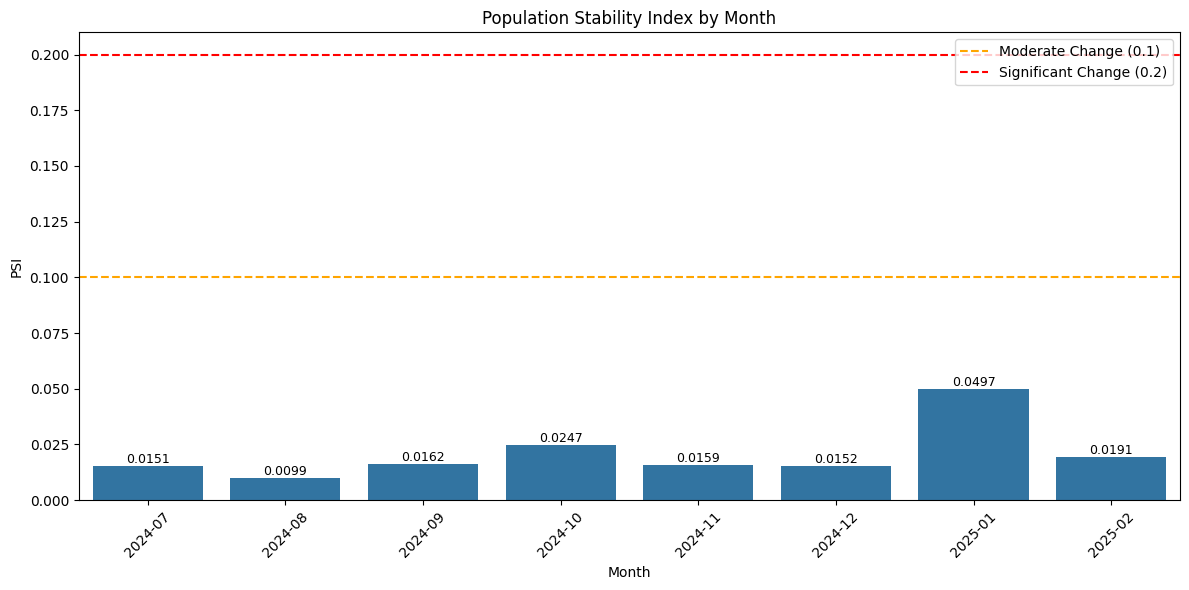

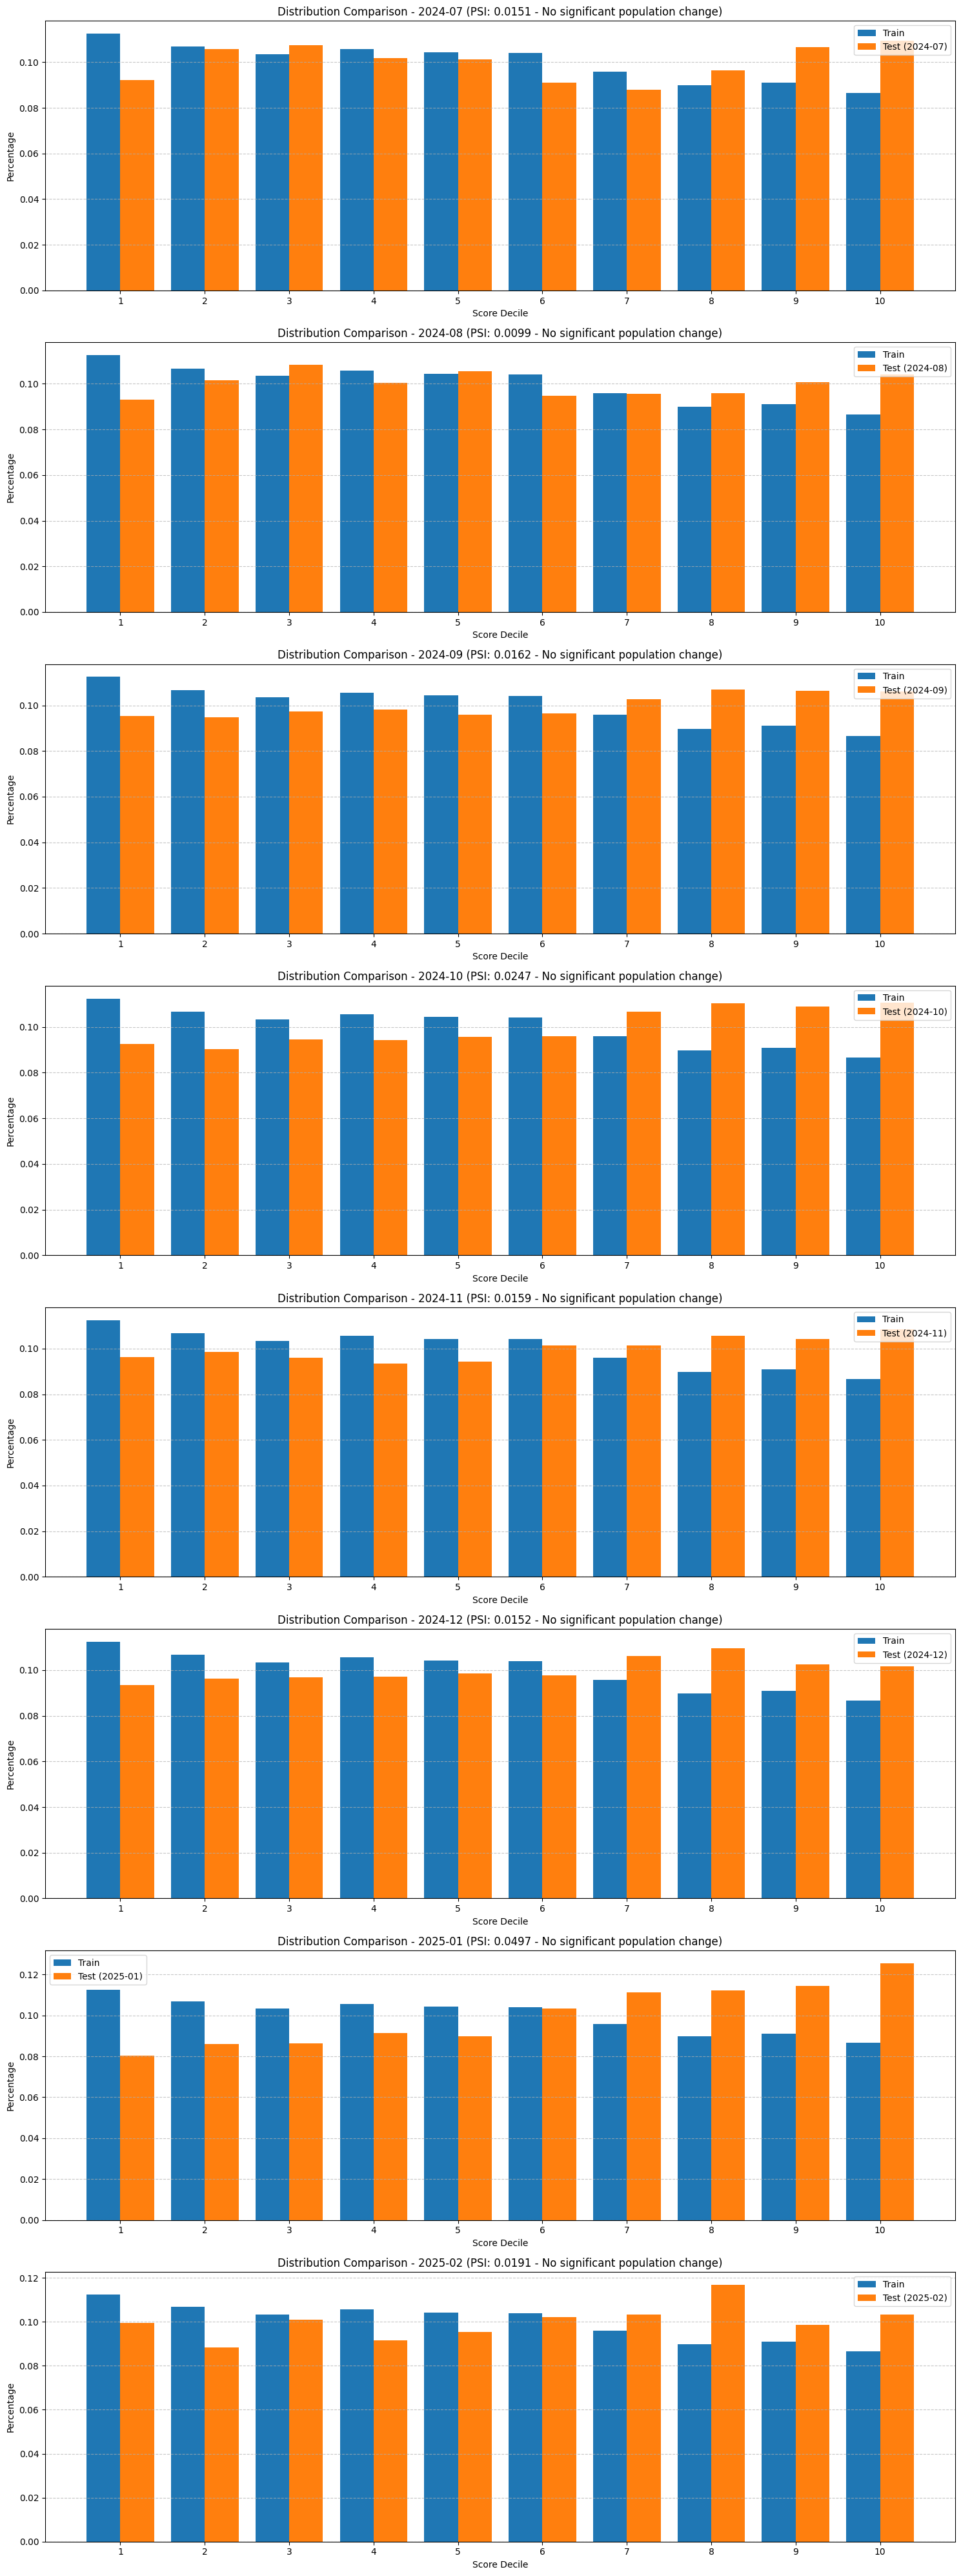

In [20]:
sq = """with base as 
(select 
  a.digitalLoanAccountId, 
  FORMAT_DATE('%Y-%m', a.ln_appln_submit_datetime) Application_month,
  FORMAT_DATE('%F', DATE_TRUNC(a.ln_appln_submit_datetime, WEEK(MONDAY))) as Appl_week_start_date,
  EXTRACT(WEEK(MONDAY) FROM a.ln_appln_submit_datetime) as Appl_week_number,
  NTILE(10) OVER (ORDER BY gen_credo_score) AS gen_credo_score_decile,
  case when date_trunc(a.ln_appln_submit_datetime, day) between '2023-07-01' and '2024-06-30' then 'Train'
       when date_trunc(a.ln_appln_submit_datetime, day) >= '2024-07-01' then 'Test'
       Else 'Other' end dataselection,
  a.gen_credo_score,
 from 
 prj-prod-dataplatform.risk_mart.sil_risk_ds_master_20230101_20250206 a
 where a.ln_loan_applied_flag = 1 and ln_dl_rule_reject_flag = 0
 and date_trunc(a.ln_appln_submit_datetime, day) >= '2023-07-01'
 and gen_credo_score is not null
 )
 select Application_month, Appl_week_start_date , dataselection, gen_credo_score_decile,
 CONCAT(MIN(round(gen_credo_score, 5)), ' - ', MAX(round(gen_credo_score, 5))) AS gen_credo_score_bin_range,
 count(distinct digitalLoanAccountId) app 
 from base where dataselection in ('Train', 'Test') 
 group by 1,2,3,4;"""
 
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')

def calculate_psi(df):
    """
    Calculate Population Stability Index (PSI) between Train set and each month in Test set
    
    Args:
        df: DataFrame with columns 'Application_month', 'dataselection', 'gen_credo_score_decile', 'app'
        
    Returns:
        DataFrame with PSI values for each Test month compared to the entire Train set
    """
    # Convert data to the right types if needed
    if isinstance(df['Application_month'].iloc[0], str):
        df['Application_month'] = pd.to_datetime(df['Application_month']).dt.strftime('%Y-%m')
    
    # Ensure gen_credo_score_decile is an integer
    df['gen_credo_score_decile'] = df['gen_credo_score_decile'].astype(int)
    
    # First, get the distribution for the entire Train set
    train_data = df[df['dataselection'] == 'Train'].copy()
    train_total = train_data['app'].sum()
    
    # Calculate the distribution percentage for each decile in Train set
    train_distribution = train_data.groupby('gen_credo_score_decile')['app'].sum().reset_index()
    train_distribution['percentage'] = train_distribution['app'] / train_total
    
    # Get unique test months
    test_data = df[df['dataselection'] == 'Test'].copy()
    test_months = test_data['Application_month'].unique()
    
    # Create a DataFrame to store PSI results
    psi_results = []
    
    # For each test month, calculate PSI
    for month in test_months:
        month_data = test_data[test_data['Application_month'] == month].copy()
        month_total = month_data['app'].sum()
        
        # Calculate the distribution percentage for each decile in this Test month
        month_distribution = month_data.groupby('gen_credo_score_decile')['app'].sum().reset_index()
        month_distribution['percentage'] = month_distribution['app'] / month_total
        
        # Merge train and month distributions
        comparison = pd.merge(
            train_distribution[['gen_credo_score_decile', 'percentage']], 
            month_distribution[['gen_credo_score_decile', 'percentage']], 
            on='gen_credo_score_decile', 
            how='outer',
            suffixes=('_train', '_test')
        ).fillna(0.0001)  # Replace NaN with small value to avoid division by zero
        
        # PSI calculation: sum((actual - expected) * ln(actual / expected))
        comparison['psi_component'] = (comparison['percentage_test'] - comparison['percentage_train']) * \
                                     np.log(comparison['percentage_test'] / comparison['percentage_train'])
        
        # Total PSI for this month
        month_psi = comparison['psi_component'].sum()
        
        psi_results.append({
            'month': month,
            'psi': month_psi,
            'distribution_comparison': comparison
        })
    
    # Create a summary DataFrame
    psi_summary = pd.DataFrame([{'month': r['month'], 'psi': r['psi']} for r in psi_results])
    
    return psi_summary, psi_results

def interpret_psi(psi_value):
    """Interpret PSI values"""
    if psi_value < 0.1:
        return "No significant population change"
    elif psi_value < 0.2:
        return "Moderate population change"
    else:
        return "Significant population change"

def plot_psi_results(psi_summary):
    """Create a bar chart of PSI values by month"""
    plt.figure(figsize=(12, 6))
    
    # Sort by month
    psi_summary = psi_summary.sort_values('month')
    
    # Create bar chart
    ax = sns.barplot(x='month', y='psi', data=psi_summary)
    
    # Add reference lines
    plt.axhline(y=0.1, color='orange', linestyle='--', label='Moderate Change (0.1)')
    plt.axhline(y=0.2, color='red', linestyle='--', label='Significant Change (0.2)')
    
    # Add labels
    plt.title('Population Stability Index by Month')
    plt.xlabel('Month')
    plt.ylabel('PSI')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # Add PSI values on top of bars
    for i, p in enumerate(ax.patches):
        ax.annotate(f"{p.get_height():.4f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=9)
    
    return plt

def plot_decile_distributions(psi_results):
    """Plot the distribution comparison for each test month"""
    plt.figure(figsize=(15, len(psi_results) * 5))
    
    for i, result in enumerate(sorted(psi_results, key=lambda x: x['month'])):
        plt.subplot(len(psi_results), 1, i+1)
        
        comparison = result['distribution_comparison']
        
        # Convert x to integer numpy array to avoid the float error
        x = comparison['gen_credo_score_decile'].astype(int).values
        
        # Plot train and test distributions
        plt.bar(x - 0.2, comparison['percentage_train'], width=0.4, label='Train')
        plt.bar(x + 0.2, comparison['percentage_test'], width=0.4, label=f'Test ({result["month"]})')
        
        plt.title(f'Distribution Comparison - {result["month"]} (PSI: {result["psi"]:.4f} - {interpret_psi(result["psi"])})')
        plt.xlabel('Score Decile')
        plt.ylabel('Percentage')
        # Use explicit integer ticks to avoid the numpy rounding error
        plt.xticks(x)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return plt

# Example usage
def main(df):
    # Calculate PSI
    psi_summary, psi_results = calculate_psi(df)
    
    # Print summary
    print("Population Stability Index Summary:")
    for _, row in psi_summary.iterrows():
        print(f"Month: {row['month']} - PSI: {row['psi']:.4f} - {interpret_psi(row['psi'])}")
    
    try:
        # Plot results
        plot_psi = plot_psi_results(psi_summary)
        plot_psi.show()
        
        # Plot decile distributions
        plot_dist = plot_decile_distributions(psi_results)
        plot_dist.show()
    except Exception as e:
        print(f"Error during plotting: {e}")
        print("Returning PSI calculations without plots")
    
    return psi_summary, psi_results

# Run the main function
psi_summary, psi_results = main(df)

gen_credo_score_psi_summary = psi_summary.copy()
gen_credo_score_psi_results = psi_results.copy()


In [21]:
gen_credo_score_psi_summary['scorename'] = 'gen_credo_score'
gen_credo_score_psi_summary

month       psi        scorename
0  2025-01  0.049738  gen_credo_score
1  2024-09  0.016205  gen_credo_score
2  2024-08  0.009884  gen_credo_score
3  2024-07  0.015092  gen_credo_score
4  2025-02  0.019120  gen_credo_score
5  2024-12  0.015241  gen_credo_score
6  2024-10  0.024709  gen_credo_score
7  2024-11  0.015944  gen_credo_score